# Extraction des données d'un poste de Météo France
Ce cahier permet de visualiser les postes de Météo-France, d'extraire les données et de les traiter.

***Sources***. Pour cartographier des postes de mesure, je me suis appuyé notamment sur des scripts écrits par Loïc Duffar (https://github.com/loicduffar/meteo.data-Tools/). Pour l'analyse des valeurs extrêmes, je me sers du travail de George Bocharov (https://georgebv.github.io/pyextremes/), et en particulier son module pyextreme.

Météo-France a deux types de postes : 
* les postes de mesures automatiques que j'appelle ici "climato",
* et les autres postes, qui sont notamment des postes de nivo-métérologie dans les stations de ski ou les balises Nivôse en altitude. 
Le problème est que si Météo-France fournit la liste des postes climatologiques sur son site internet, elle ne le fait pas pour les autres postes. Le seul moyen de le savoir est de télécharger tous les fichiers et examiner les numéros de poste. Un script "création-liste-poste.ipynb" fait ce travail fastidieux ; ce script génère une liste des postes non recensés par Météo-France et crée un fichier xlsx avec la localisation et d'autres informations sur ces postes. 

Il faut renseigner :
* l'adresse du répertoire où se situe le fichier, ici 
```
répertoire_postes = '/home/ancey/Météo-France/postes/'
```
* le nom du fichier, ici 
```
fichier_postes_alpes = 'liste_synthétique_Alpes_Nord.xlsx'
```
***Dépendance***. Les modules suivants sont nécessaires : datetime, json, requests, plotly, gzip, scipy, openpyxl, pyextremes, termcolor.

L'installation peut se faire via pip ou conda. Il faut entièrement initialiser le code (les deux boîtes de "Initalisatoon et lecture du fichier JSON").

* Version 17 juin 2024 (modifications à la suite de la mise à jour de pandas)
* Version 23 juin 2024 (amélioration des cartes)
* Version 29 juin 2024 (ajout Pyrénées, correction de bogues)
* Version 15 juin 2025 (mise à jour pour la correction automatique des années ; la partie consacrée à Safran a été déplacée dans safran_extraction.ipynb)

## Initialisation et lecture du fichier JSON  de Météo France

In [1]:
%matplotlib inline
import pandas as pd
# pd.set_option('display.max_rows', None)        # à décommenter si on veut afficher tout le dataframe
import numpy as np
import os
import sys
import datetime
import json
import requests
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib import colors as mcolors
colors = mcolors._colors_full_map
import gzip
import shapely
import geopandas as gpd
from tqdm import tqdm                             # barre de progression
from scipy import stats                           # lois de probabilité (valeurs extrêmes)
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import gumbel_r, genextreme      # valeurs extrêmes
import openpyxl                                   # exporte excel
from pyextremes import EVA                        # valeurs extrêmes  
from termcolor import colored                     # coloration du texte
import geopy.distance                             # distance en coordonnées (lat, lon)
import xarray as xr                               # gestion des xarray
import cartopy.crs as ccrs                        # cartographie
import cartopy.feature as cfeature
from cartopy.io.img_tiles import GoogleTiles
from cartopy.io import PostprocessedRasterSource, LocatedImage
from cartopy.io.srtm import SRTM3Source, SRTM1Source
from tabulate import tabulate                     # impression du texte dans un format tabulé
import yaml

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LightSource
from matplotlib.colors import PowerNorm
from shapely.vectorized import contains
from scipy.ndimage import zoom
from scipy.ndimage import gaussian_filter
import rioxarray
from rasterio.enums import Resampling


plt.rcParams['text.usetex'] = True                # paramètres latex
plt.rcParams['text.latex.preamble'] = '\\usepackage{libertine}'
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
plt.style.use('default')
################################
## Auteur : Christoophe Ancey ##
## Date : Mai 2024            ##
## Mise à jour : juin 205     ##
################################

#-------------------------------------------
# Lecture du fichier de postes  
#-------------------------------------------
# adresse du répertoire de travail
répertoire_base      = '/home/ancey/Météo-France/'
répertoire_principal = répertoire_base + 'meteo.data/base'
print("Je suis dans le répertoire : ", répertoire_base)
# teste si le répertoire existe
if not os.path.exists(répertoire_principal):
    # s'il n'existe pas le créer
    os.makedirs(répertoire_principal)
    print("J'ai créé le répertoire : ", répertoire_principal)
else:
    print("J'ai trouvé le répertoire : ", répertoire_principal)
 
os.chdir(répertoire_principal)
print("Je me place dans le répertoire : "+os.getcwd())

# Ma liste de postes sur le disque
répertoire_postes    = '/home/ancey/Météo-France/postes/'         # mon répertoire de travail
fichier_postes_alpes = 'liste_synthétique_Alpes_Nord.xlsx'        # à changer selon le travail à faire
fichier_postes_nivo  = 'postesNivo.csv'                           # postes nivo-obs
if os.path.exists(répertoire_postes):
    liste_fichier = [f for f in os.listdir(répertoire_postes) if os.path.isfile(os.path.join(répertoire_postes, f))]
    if fichier_postes_alpes  in liste_fichier: 
        liste_postes_alpes = pd.read_excel(os.path.join(répertoire_postes,fichier_postes_alpes), dtype={'poste':str})
        liste_postes_nivo  = pd.read_csv(os.path.join(répertoire_postes,fichier_postes_nivo), dtype={'ID':str})
        liste_postes_alpes['poste']  = liste_postes_alpes['poste'].apply(lambda x: x.strip())
        print("J'ai téléchargé le fichier ", fichier_postes_alpes)
        # ce booléen indique si le fichier "fichier_postes_alpes" a été chargé
        chargement_nivo = True
    else:
        print(colored("Je n'ai pas trouvé de fichier des postes dans le répertoire principal.",'red'))
        print("Ce dernier peut être généré avec création_liste_postes.ipynb")
        chargement_nivo = False

# Météo France fournit un fichier JSON avec la liste de tous les postes
url_liste_postes= "https://www.data.gouv.fr/fr/datasets/r/1fe544d8-4615-4642-a307-5956a7d90922"
# Lecture en ligne du fichier JSON avec test de la connexion
requête = requests.get(url_liste_postes)
# teste si le fichier en ligne existe
if requête.status_code == 200:
    print("J'ai trouvé le fichier de Météo-France sur leur site. Je poursuis....")
    data_json= requête.json()
elif requête.status_code == 404:
    print(colored("Erreur : fichier non trouvé !",'red'))
    sys.exit()
else:
    print(colored("La requête a échoué. Le code d'erreur est ",'red'), requête.status_codes)
    sys.exit()
# il faut prendre le transposé (si cela plante, enlever ".T"). 
# MF semble ne pas fournir tout le temps le même format de fichier
metadata_MF = pd.DataFrame(data_json['features']).T

if metadata_MF.keys().to_list() != ['geometry', 'type', 'properties']:
    metadata_MF = pd.DataFrame(data_json['features'])

#-------------------------------------------
# Dictionnaires 
#-------------------------------------------
# début des mesures au niveau départemental
an_début_département = {}
an_début_département['01'] = '1852'
an_début_département['04'] = '1872'
an_début_département['05'] = '1877'
an_début_département['06'] = '1877'
an_début_département['25'] = '1852'
an_début_département['26'] = '1877'
an_début_département['38'] = '1872'
an_début_département['73'] = '1871'
an_début_département['74'] = '1876'
an_début_département['09'] = '1872'
an_début_département['31'] = '1809'
an_début_département['64'] = '1865'
an_début_département['65'] = '1863'
an_début_département['66'] = '1850'
liste_départements = {'01','04','05','06','09','25','26','31','38','64','65','66','73','74'}

url_M1_département = {}
url_M2_département = {}
url_M3_département = {}
url_N1_département = {}
url_N2_département = {}
url_N3_département = {}

# adresse url de base
date_calcul        = datetime.date.today()
année_en_cours     = date_calcul.year 
suffixe = '_latest-'+str(année_en_cours-1)+'-'+str(année_en_cours)


base_url = 	"https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/BASE/QUOT/Q_"
for département in liste_départements:
      url_N1_département[département] = base_url+département+"_"+an_début_département[département]+'-1949_autres-parametres.csv.gz'
      url_N2_département[département] = base_url+département+'_previous-1950-'+str(année_en_cours-2)+'_autres-parametres.csv.gz'
      url_N3_département[département] = base_url+département+suffixe+'_autres-parametres.csv.gz'
      url_M1_département[département] = base_url+département+"_"+an_début_département[département]+'-1949_RR-T-Vent.csv.gz'
      url_M2_département[département] = base_url+département+'_previous-1950-'+str(année_en_cours-2)+'_RR-T-Vent.csv.gz'
      url_M3_département[département] = base_url+département+suffixe+'_RR-T-Vent.csv.gz'

# Dictionnaire des noms de département
noms_département = dict()
noms_département['73'] = "Savoie"
noms_département['74'] = "Haute-Savoie"
noms_département['38'] = "Isère"
noms_département['05'] = "Hautes-Alpes"
noms_département['04'] = "Alpes-de-Haute-Provence"
noms_département['06'] = "Alpes-Maritimes"
noms_département['01'] = "Ain"
noms_département['25'] = "Doubs"
noms_département['26'] = "Drôme"
noms_département['09'] = "Ariège"
noms_département['31'] = "Haute-Garonne"
noms_département['64'] = "Pyrénées-Atlantiques"
noms_département['65'] = "Hautes-Pyrénées"
noms_département['66'] = "Pyrénées-Orientales"


#-------------------------------------------
# Fonctions 
#-------------------------------------------
def lecture_bool(x:bool): 
      """
      transforme un booléen en mot "oui" ou "non"
      """
      if x: return "oui"
      else:
            return "non"

# fonction pour télécharger les fichiers MF
def télécharger_fichier(url, nom_fichier, work_verbosity = True):
    """
    télécharge le fichier situé l'adresse url et le place dans le 
    répertoire principale avec le nom "nom_fichier"
    La variable verbosity permet de savoir s'il y a des erreurs.
    """
    fichier = os.path.join(répertoire_principal, nom_fichier) + '.gz'
    if os.path.isfile(fichier):
        if work_verbosity: print("Rien à faire. Le fichier est déjà présent.")
    else:
        requête_données = requests.get(url)
        if requête_données.status_code == 200:
            with open(fichier,mode='wb') as file:
             file.write(requête_données.content)
            if work_verbosity: print('Téléchargement : ', fichier)    
        else:
            print(colored("Le lien "+ url+ "ne marche pas !",'red'))
            sys.exit()

# fonction pour décompresser les fichiers MF
def décompresser_archive(archive, work_verbosity = True):
    """
    décompresse l'archive
    """
    fichier             = os.path.join(répertoire_principal, archive) + '.gz'
    fichier_décompressé = os.path.join(répertoire_principal, archive) + '.csv'
    if os.path.isfile(fichier_décompressé):
        if work_verbosity: print("Rien à faire. Le fichier est déjà présent.")
    else:
        if os.path.exists(fichier):
            with gzip.open(fichier, mode='rb') as f_in:
                with open(fichier_décompressé, mode='wb') as f_out:
                    f_out.write(f_in.read())
            if work_verbosity: print('Archive décompressée : ', fichier)
        else:
            print(colored("L'archive ", fichier, " n'est pas présente !",'red'))
            print("Téléchargez tout d'abord l'archive...")

def Lire_liste_postes(département):
    """
    fournit la liste des postes et de leurs caractéristiques dans un département.
    liste_tous_postes correspond à la liste dans le fichier liste_postes_alpes tandis que
    selection correspond à la liste dans le fichier des postes climatos
    """
    selection        = metadata_MF[metadata_MF['num_poste'].str.startswith(département)]
    selection_nivo   = liste_postes_alpes[liste_postes_alpes['poste'].str.startswith(département)]
    df1 = pd.DataFrame()
    df1['nom'] = selection['nom_usuel'].apply(lambda x: x.title())
    df1['numéro'] = selection['num_poste']
    df1['alt'] = selection['alti']
    df1['lat'] = selection['lat']
    df1['lon'] = selection['lon']
    df1['type'] = 'poste MF'
    df2 = pd.DataFrame()
    df2['nom'] = selection_nivo['nom']
    df2['numéro'] = selection_nivo['poste']
    df2['alt'] = selection_nivo['alt']
    df2['lat'] = selection_nivo['lat']
    df2['lon'] = selection_nivo['lon']
    df2['type'] = 'nivo'
    if not df2['numéro'].eq(df1['numéro']).any():
        liste_tous_postes = pd.concat([df1,df2], ignore_index=True)
    liste_tous_postes = liste_tous_postes.sort_values(by=['nom'])
    liste_tous_postes = liste_tous_postes.reset_index(drop = True)
    return liste_tous_postes, selection

def trouver_période_continue(liste):
    """ 
    fournit l'ensemble des sous-listes telles que chacun des éléments est séparé de l'élément par 1.
    Cette fonction permet de déterminer dans la série d'années avec des cumuls non nuls les séries continues
    d'années.
    """
    res, last = [[]], None
    for x in liste:
        if last is None or abs(last - x) ==1:
            res[-1].append(x)
        else:
            res.append([x])
        last = x
    return res


#### google : ajout du relief ####

class ShadedReliefESRI(GoogleTiles):
    # shaded relief
    def _image_url(self, tile):
        x, y, z = tile
        url = ('https://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg').format(
               z=z, y=y, x=x)
        return url
relief = ShadedReliefESRI()

def shade(located_elevations):
    """
    Given an array of elevations in a LocatedImage, add a relief (shadows) to
    give a realistic 3d appearance.

    """
    new_img = srtm.add_shading(located_elevations.image,
                               azimuth=135, altitude=15)
    return LocatedImage(new_img, located_elevations.extent)

Je suis dans le répertoire :  /home/ancey/Météo-France/
J'ai trouvé le répertoire :  /home/ancey/Météo-France/meteo.data/base
Je me place dans le répertoire : /home/ancey/Météo-France/meteo.data/base
J'ai téléchargé le fichier  liste_synthétique_Alpes_Nord.xlsx
J'ai trouvé le fichier de Météo-France sur leur site. Je poursuis....


In [2]:
# Ajout de colonnes 
metadata_MF['lat']      = metadata_MF['geometry'].apply(lambda x: x['coordinates'][1]).astype(float)
metadata_MF['lon']      = metadata_MF['geometry'].apply(lambda x: x['coordinates'][0]).astype(float)
metadata_MF['nom_usuel']= metadata_MF['properties'].apply(lambda x: x['NOM_USUEL'].strip())
metadata_MF['num_poste']= metadata_MF['properties'].apply(lambda x: x['NUM_POSTE'].strip())
#souci avec le fichier MF pour les communes (octobre 2024)
try:
    metadata_MF['commune']  = metadata_MF['properties'].apply(lambda x: x['COMMUNE'].strip() )
except AttributeError:
    metadata_MF['commune']  = metadata_MF['properties'].apply(lambda x: x['COMMUNE']  )
metadata_MF['ficheClimComplete'] = metadata_MF['properties'].apply(lambda x: x['ficheClimComplete']).astype(float)
metadata_MF['ficheClimReduite']  = metadata_MF['properties'].apply(lambda x: x['ficheClimReduite']).astype(float)
metadata_MF['alti']              = metadata_MF['properties'].apply(lambda x: x['ALTI'])

# sauvegarde dans un fichier excel plus lisible que le JSON après suppression des colonnes type, geometry et properties
metadata_MF.drop(['type', 'geometry', 'properties'], axis=1, inplace=True)

# ajoute une colonne à metadata_MF avec une url composée de la concaténation d'une racine constante et du numéro de poste
metadata_MF['url_metadata']     = 'https://publitheque.meteo.fr/okapi/_composantsHTML/refGeo/pageInfosStation.jsp?insee='+ metadata_MF['num_poste']
metadata_MF['ficheClimComplete']= metadata_MF['ficheClimComplete'].astype(int)
metadata_MF['ficheClimReduite'] = metadata_MF['ficheClimReduite'].astype(int)
# trie suivant num_poste
metadata_MF.sort_values(by= ['num_poste'], inplace=True)
display(metadata_MF)

lat         lon                nom_usuel num_poste     commune  \
0     46.278167    5.669000                   ARBENT  01014002      ARBENT   
1     45.833000    5.106667               BALAN_AERO  01027003       BALAN   
2     46.122000    4.904500                  BANEINS  01028001     BANEINS   
3     46.086500    5.814167               BELLEGARDE  01033002  VALSERHONE   
4     45.769333    5.688000                   BELLEY  01034004      BELLEY   
...         ...         ...                      ...       ...         ...   
2401 -21.318167  165.002167                   NEPOUI  98827002        POYA   
2402 -20.789333  165.254500              TOUHO AEROD  98830002       TOUHO   
2403 -22.156500  166.939000                YATE MRIE  98832002        YATE   
2404 -22.132667  166.726333          RIVIERE BLANCHE  98832006        YATE   
2405 -22.269167  166.967500  GORO_ANCIENNE_PEPINIERE  98832101        YATE   

      ficheClimComplete  ficheClimReduite  alti  \
0                     0                 1   534   
1                     0                 0   196   
2                     0                 1   243   
3                     1                 1   350   
4                     0                 1   330   
...                 ...               ...   ...   
2401                  1                 1    82   
2402                  0                 1     2   
2403                  0                 1    25   
2404                  0                 1   171   
2405                  0                 1   298   

                                           url_metadata  
0     https://publitheque.meteo.fr/okapi/_composants...  
1     https://publitheque.meteo.fr/okapi/_composants...  
2     https://publitheque.meteo.fr/okapi/_composants...  
3     https://publitheque.meteo.fr/okapi/_composants...  
4     https://publitheque.meteo.fr/okapi/_composants...  
...                                                 ...  
2401  https://publitheque.meteo.fr/okapi/_composants...  
2402  https://publitheque.meteo.fr/okapi/_composants...  
2403  https://publitheque.meteo.fr/okapi/_composants...  
2404  https://publitheque.meteo.fr/okapi/_composants...  
2405  https://publitheque.meteo.fr/okapi/_composants...  

[2406 rows x 9 columns]

## Trace la carte des postes actifs

In [3]:
# trace une carte plotly des points et sauvegarde tout dans des fichier excel, html et png
fig = px.scatter_mapbox(metadata_MF, 'lat', lon= 'lon', 
                        hover_name= "nom_usuel", hover_data= ["num_poste", 'alti', "commune", 'ficheClimComplete', 'ficheClimReduite'], 
                        zoom=5, height= 800, width= 900, 
                        )


title = 'Postes Météo-France en activité en ' + str(année_en_cours)
fig.update_layout(title_text= title, title_x=0.5  , hoverlabel= dict(bgcolor= 'rgb(255,255,255)'))
fig.update_traces(marker=dict(color='red'))

#===================== Ajoute une couche des départements français à partir d'un fichier GeoJSON
fig.update_layout(mapbox_layers=[
    {
        "sourcetype": "geojson",
        # "source": "https://france-geojson.gregoiredavid.fr/repo/departements.geojson",
        "source": "https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb", 
        "type": "line",
        "color": "rgba(0, 0, 0, 0.9)",
        "line": {"width": 1}
    }
    ])
fig.update_layout(mapbox_style= "open-street-map", mapbox_zoom=5, mapbox_center = {"lat": 46.5, "lon": 2.}
                  )


### Export

In [12]:
# Export vers html
file_start= 'postes_meteo-france'
file_map= file_start + '- carte_' + str(année_en_cours)
fig.write_html(os.path.join(répertoire_principal, file_map + '.html'))

In [13]:
# Export PNG
file_start= 'postes_meteo-france'
file_map= file_start + '_carte_' +  str(année_en_cours)
file_png= os.path.join(répertoire_principal, file_map + '.png')
fig.write_image(file_png)

In [14]:
# Export vers Excel du fichier JSON + ajout des urls de fiche de métadonnées
file_excel   = os.path.join(répertoire_principal, file_start + ' - liste_' +  str(année_en_cours)+ '.xlsx')
onglet_liste = 'liste'
metadata_MF.to_excel(file_excel, index=False, sheet_name= onglet_liste)

wb = openpyxl.load_workbook(file_excel) # Chargement du classeur existant
ws = wb[onglet_liste] # récupère onglet_liste
#ws.add_image(openpyxl.drawing.image.Image(file_png), 'J3') # ajoute l'image png de la carte
# ajoute un texte
ws['N1']= 'Version geoJSON'
ws['P1']= 'https://gist.github.com/2803media/84acfec402ce2210f5c38e6d7de3f39b'

# Ajoute un nouvel onglet au fichier excel, avec une brute de json.dumps(data_json, indent=4)
onglet_json= 'JSON'
ws = wb.create_sheet(onglet_json) # Création d'une nouvelle feuille
for i, line in enumerate(json.dumps(data_json, indent=4).split('\n'), start=1): # Ajout de la chaîne ligne par ligne à la nouvelle feuille
    ws[f'A{i}'] = line

wb.save(file_excel) # Sauvegarde du classeur



## Carte pour un département

In [10]:
# interroge les poste d'un département donné
département= '73'
# sélection des données du département choisi
selection=metadata_MF[metadata_MF['num_poste'].str.startswith(département)]
# calcul du centre du département (latitude et longitude)
m_lat=np.mean(np.array(selection.lat))
m_lon=np.mean(np.array(selection.lon))


if chargement_nivo: liste_tous_postes, _ = Lire_liste_postes(département)

### Carte des postes climatologiques

In [ ]:
# trace une carte plotly des points et sauvegarde tout dans des fichier excel, html et png
fig = px.scatter_mapbox(selection, 'lat', lon= 'lon', 
                        hover_name= "nom_usuel", hover_data= ["num_poste", 'alti', "commune", 'ficheClimComplete', 'ficheClimReduite'], 
                        height= 800, width= 900, 
                        )

 
title= noms_département[département] + ' : postes Météo-France en activité en ' +  str(année_en_cours)
fig.update_layout(title_text= title, title_x=0.5  , hoverlabel= dict(bgcolor= 'rgb(255,255,255)'))
fig.update_traces(marker=dict(color='red'))

#===================== Ajoute une couche des départements français à partir d'un fichier GeoJSON
fig.update_layout(mapbox_layers=[
    {
        "sourcetype": "geojson",
        # "source": "https://france-geojson.gregoiredavid.fr/repo/departements.geojson",
        "source": "https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb", 
        "type": "line",
        "color": "rgba(0, 0, 0, 0.9)",
        "line": {"width": 1}
    }
    ])
fig.update_layout(mapbox_style= "open-street-map", mapbox_zoom=8, mapbox_center = {"lat": m_lat, "lon": m_lon})


fig

In [12]:
# Export PNG
racine_carte = 'postes_climato_meteo-france'
nom_carte    = racine_carte + '_carte_' + str(année_en_cours)
nom_complet  = os.path.join(répertoire_principal, nom_carte + '.png')
fig.write_image(nom_complet)


### Carte de tous les postes

In [ ]:

if chargement_nivo:
    fig = px.scatter_mapbox(liste_tous_postes, lat ='lat', lon= 'lon',  
                        hover_name= "nom", hover_data= ["numéro", 'alt','type'], 
                        zoom=5, height= 800, width= 900,   
                        color = 'type'
                        )

    fig.update_traces(
        marker=go.scattermapbox.Marker(
            size=10,
            opacity=1.0
        )
    )
 
    #===================== Ajoute une couche des départements français à partir d'un fichier GeoJSON
    fig.update_layout(mapbox_layers=[
    {
        "sourcetype": "geojson",
        # "source": "https://france-geojson.gregoiredavid.fr/repo/departements.geojson",
        "source": "https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb", 
        "type": "line",
        "color": "rgba(0, 0, 0, 0.9)",
        "line": {"width": 1}
    }
    ])
    fig.update_layout(mapbox_style= "open-street-map", mapbox_zoom=8, mapbox_center = {"lat": m_lat, "lon": m_lon})

    fig.show()
else:
    print("La carte ne peut être affichée car les données des postes nivologiques n'ont pas été chargées.")

# Export PNG
racine_carte = 'tous_postes_meteo-france'
nom_carte    = racine_carte + '_carte_' + str(année_en_cours)
nom_complet  = os.path.join(répertoire_principal, nom_carte + '.png')
fig.write_image(nom_complet)


### Poste de Nivo-obs

In [15]:
fig = px.scatter_mapbox(liste_postes_nivo, lat ='Latitude', lon= 'Longitude',  
                        hover_name= "ID", hover_data= ["ID", 'Nom'], 
                        zoom=5, height= 800, width= 900
                        )

fig.update_traces(
        marker=go.scattermapbox.Marker(
            size=10,
            opacity=1.0
        )
    )
 
    #===================== Ajoute une couche des départements français à partir d'un fichier GeoJSON
fig.update_layout(mapbox_layers=[
    {
        "sourcetype": "geojson",
        # "source": "https://france-geojson.gregoiredavid.fr/repo/departements.geojson",
        "source": "https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb", 
        "type": "line",
        "color": "rgba(0, 0, 0, 0.9)",
        "line": {"width": 1}
    }
    ])
fig.update_layout(mapbox_style= "open-street-map", mapbox_zoom=8, mapbox_center = {"lat": m_lat, "lon": m_lon})

fig.show()

### Liste des stations pour un département

In [16]:
if chargement_nivo:
      information_selection = (liste_tous_postes.sort_values(by=['nom']))[['nom','numéro','alt']]
else:
      information_selection = (selection.sort_values(by=['commune']))[['num_poste','commune','nom_usuel','alti']]
      #print(tabulate(information_selection, showindex=False, headers=metadata_MF.columns)) 
information_selection = information_selection.drop_duplicates(subset=['nom'])
display((information_selection.style.hide()).set_properties(**{'text-align': 'left'}))


# Analyse d'un poste quelconque (nivo ou climato)

Cette partie nécessite que chargement_nivo = True et que le fichier ait été téléchargé.

## Initialisation

In [3]:
poste_choisi = '73304002' # Val d'Isère Le Molard 
poste_choisi = '73304003' # Val d'Isère Garage 

poste_choisi = '73304004' # Val d'Isère Joseray

poste_choisi = '73304001' # Val d'Isère Presbytère



poste_choisi = '73290002' # Termignon
poste_choisi = '73144404' # Val Cenis La Berche
poste_choisi = '73144001' # Val Cenis, La Ramasse

département = poste_choisi[0:2]
if chargement_nivo:
      liste_tous_postes, selection = Lire_liste_postes(département)
      if liste_tous_postes[liste_tous_postes['numéro']==poste_choisi].empty:
            print("Erreur : je n'ai pas de données pour ce poste !")
      else:
            information_poste = liste_tous_postes[liste_tous_postes['numéro']==poste_choisi]
            print("Le poste a été trouvé dans la liste des postes.")
else:
      print(colored("Je n'ai pas téléchargé de fichier de tous les postes. Il faut le faire avec création_liste_postes.ipynb !",'red'))
      try:
            selection
      except NameError:
            selection=metadata_MF[metadata_MF['num_poste'].str.startswith(département)]
      if selection[selection['num_poste']==poste_choisi ].empty:
            print(colored("Pas de poste dans le fichier des postes actifs. Vérifier les données...",'red'))

Le poste a été trouvé dans la liste des postes.


In [4]:
#liste_postes_alpes = liste_postes_alpes.drop_duplicates(subset=['poste'])
#liste_tous_postes  = liste_tous_postes.drop_duplicates(subset=['numéro'])
information = liste_postes_alpes[liste_postes_alpes['poste']==poste_choisi]

existe_pluie = information['pluie'].to_numpy()[0]
existe_neige = information['neige'].to_numpy()[0]
existe_HN    = information['HN'].to_numpy()[0]
existe_TN    = information['TN'].to_numpy()[0]
existe_TM    = information['TM'].to_numpy()[0]
existe_TX    = information['TX'].to_numpy()[0]
date_début   = information['début'].to_numpy()[0]
date_fin     = information['fin'].to_numpy()[0]
nom_poste    = information['nom'].to_numpy()[0]
nom_commune  = information['nom'].to_numpy()[0]
latitude_poste  = information['lat'].to_numpy()[0]
longitude_poste = information['lon'].to_numpy()[0]

print(tabulate([
      ['Numéro  ', poste_choisi], 
      ['Nom  ', nom_poste ],
      ['Département  ',noms_département[département]],
      ['Altitude  ', str(information['alt'].to_numpy()[0])+' m' ],
      ['latitude  ', str(latitude_poste)+'°' ],
      ['longitude ', str(longitude_poste)+'°' ],
      ['Nombre de valeurs  ', information['valeurs'].to_numpy()[0] ],
      ['Date de début  ', datetime.datetime.strptime(date_début,"%Y-%m-%d").strftime("%d/%m/%Y")  ],
      ['Date de fin  ',   datetime.datetime.strptime(date_fin,"%Y-%m-%d").strftime("%d/%m/%Y")  ],
      ['Cumul de pluie',       lecture_bool(existe_pluie)],
      ['Cumul de neige',       lecture_bool(existe_neige)],
      ['Hauteur de neige',     lecture_bool(existe_HN)],
      ['Température moyenne',  lecture_bool(existe_TM)],
      ['Température minimale', lecture_bool(existe_TN)],
      ['Température maximale', lecture_bool(existe_TX)]
      ] ,  tablefmt='orgtbl'))
url_poste_choisi = 'https://publitheque.meteo.fr/okapi/_composantsHTML/refGeo/pageInfosStation.jsp?insee='+poste_choisi
print('\n Lien vers la fiche du poste : ', url_poste_choisi)

| Numéro               | 73144001   |
| Nom                  | Mont Cenis |
| Département          | Savoie     |
| Altitude             | 2032 m     |
| latitude             | 45.269333° |
| longitude            | 6.899167°  |
| Nombre de valeurs    | 23405      |
| Date de début        | 09/01/1992 |
| Date de fin          | 13/06/2025 |
| Cumul de pluie       | oui        |
| Cumul de neige       | oui        |
| Hauteur de neige     | non        |
| Température moyenne  | oui        |
| Température minimale | oui        |
| Température maximale | oui        |

 Lien vers la fiche du poste :  https://publitheque.meteo.fr/okapi/_composantsHTML/refGeo/pageInfosStation.jsp?insee=73144001


In [5]:
# calcule la distance par rapport au poste choisi
distance_poste = lambda lat, lon: geopy.distance.geodesic((lat, lon), (latitude_poste, longitude_poste)).km
# rayon de recherche
rayon_recherche = 10
print("---------------------------------------------------------------------")
print(colored("-------------- Liste des postes dans un rayon de {:d} km --------------".format(int(rayon_recherche)),'cyan'))
print("---------------------------------------------------------------------")
print(tabulate(liste_tous_postes[liste_tous_postes.apply(lambda x: distance_poste(x.lat, x.lon ), axis = 1)<rayon_recherche]))


print("---------------------------------------------------------------------")
print(colored("---- Liste des postes de nivo-observation dans un rayon de {:d} km ----".format(int(rayon_recherche)),'cyan'))
print("---------------------------------------------------------------------")
print(tabulate(liste_postes_nivo[liste_postes_nivo.apply(lambda x: distance_poste(x.Latitude, x.Longitude ), axis = 1)<rayon_recherche]))

---------------------------------------------------------------------
-------------- Liste des postes dans un rayon de 10 km --------------
---------------------------------------------------------------------
---  ------------------------------  --------  ----  -------  -------  --------
 34  Bessans                         73040400  1713  45.3207  6.99533  nivo
 35  Bessans Averole                 73040002  2025  45.32    6.99167  nivo
117  Lanslebourg Anc                 73143010  1925  45.2867  6.875    nivo
118  Lanslebourg Bou                 73143004  1400  45.2867  6.875    nivo
119  Lanslebourg Mt                  73143003  2000  45.2235  6.94467  nivo
120  Lanslebourg Nv                  73143001  2100  45.2867  6.875    nivo
121  Lanslebourg-Mont-Cenis          73143002  1720  45.2867  6.875    nivo
122  Lanslebourg-Mont-Cenis-Barrage  73143011  1200  45.2867  6.875    nivo
123  Lanslebourg-Mont-Cenis-Fort     73143006  1400  45.2867  6.875    nivo
145  Mont Cenis           

In [6]:
# Chargement des fichiers nécessaires depuis le site de Météo-France en fonction de la date de début
# Données postérieures à 1949

an_début = int(datetime.datetime.strptime(date_début,"%Y-%m-%d").strftime("%Y"))
if 1950<=an_début<=année_en_cours-2: 
      if existe_pluie:
            données_pluie = pd.DataFrame()
            liste_url = [url_M2_département[département], url_M3_département[département] ]
            # boucle pour chaque fichier M 
            for indice_fichier in tqdm(range(2)):
                  archive = 'archives_pluie_'+str(indice_fichier)+'_'+département
                  télécharger_fichier( liste_url[indice_fichier], archive, work_verbosity = True) 
                  décompresser_archive(archive, work_verbosity = True)
                  fichier = os.path.join(répertoire_principal, archive) + '.csv'
                  données_totales = pd.read_csv(fichier, sep=";", encoding= 'utf-8',parse_dates=["AAAAMMJJ"],  
                                                dtype={"NUM_POSTE":str})
                  données_totales['NUM_POSTE']= données_totales['NUM_POSTE'].apply(lambda x: x.strip())
                  selection_poste = données_totales[données_totales['NUM_POSTE']==poste_choisi]
                  données_pluie = pd.concat([données_pluie, selection_poste[['AAAAMMJJ','RR','TM','TN','TX']].copy()])
            données_pluie = données_pluie.rename(columns={"AAAAMMJJ": "date", "RR": "pluie"})

      if not existe_pluie and existe_TM:
            données_pluie = pd.DataFrame()
            liste_url = [url_M2_département[département], url_M3_département[département] ]
            # boucle pour chaque fichier M 
            for indice_fichier in tqdm(range(2)):
                  archive = 'archives_pluie_'+str(indice_fichier)+'_'+département
                  télécharger_fichier( liste_url[indice_fichier], archive, work_verbosity = True) 
                  décompresser_archive(archive, work_verbosity = True)
                  fichier = os.path.join(répertoire_principal, archive) + '.csv'
                  données_totales = pd.read_csv(fichier, sep=";", encoding= 'utf-8',parse_dates=["AAAAMMJJ"],  
                                                dtype={"NUM_POSTE":str})
                  données_totales['NUM_POSTE']= données_totales['NUM_POSTE'].apply(lambda x: x.strip())
                  selection_poste = données_totales[données_totales['NUM_POSTE']==poste_choisi]
                  données_pluie = pd.concat([données_pluie, selection_poste[['AAAAMMJJ', 'TM','TN','TX']].copy()])
            données_pluie = données_pluie.rename(columns={"AAAAMMJJ": "date" })

      if existe_neige and existe_HN:
            données_neige = pd.DataFrame()
            liste_url = [url_N2_département[département], url_N3_département[département] ]
            # boucle pour chaque fichier M 
            for indice_fichier in tqdm(range(2)):
                  archive = 'archives_neige_'+str(indice_fichier)+'_'+département
                  télécharger_fichier( liste_url[indice_fichier], archive, work_verbosity = True) 
                  décompresser_archive(archive, work_verbosity = True)
                  fichier = os.path.join(répertoire_principal, archive) + '.csv'
                  données_totales = pd.read_csv(fichier, sep=";", encoding= 'utf-8',parse_dates=["AAAAMMJJ"], 
                                                dtype={"NUM_POSTE":str})
                  données_totales['NUM_POSTE']= données_totales['NUM_POSTE'].apply(lambda x: x.strip())
                  selection_poste = données_totales[données_totales['NUM_POSTE']==poste_choisi]
                  données_neige = pd.concat([données_neige, selection_poste[['AAAAMMJJ','HNEIGEF','NEIGETOTX']].copy()])
            données_neige = données_neige.rename(columns={"AAAAMMJJ": "date", "HNEIGEF": "neige", "NEIGETOTX": "HN"})
            if np.nanmax(np.array(données_neige['HN']))==0: 
                    print(colored("Les données relatives à l'épaisseur du manteau neigeux sont renseignées, mais toutes nulles...",'red'))
                    existe_HN = False

      if existe_neige and not existe_HN:
            données_neige = pd.DataFrame()
            liste_url = [url_N2_département[département], url_N3_département[département] ]
            # boucle pour chaque fichier M 
            for indice_fichier in tqdm(range(2)):
                  archive = 'archives_neige_'+str(indice_fichier)+'_'+département
                  télécharger_fichier( liste_url[indice_fichier], archive, work_verbosity = True) 
                  décompresser_archive(archive, work_verbosity = True)
                  fichier = os.path.join(répertoire_principal, archive) + '.csv'
                  données_totales = pd.read_csv(fichier, sep=";", encoding= 'utf-8',parse_dates=["AAAAMMJJ"],
                                                dtype={"NUM_POSTE":str})
                  données_totales['NUM_POSTE']= données_totales['NUM_POSTE'].apply(lambda x: x.strip())
                  selection_poste = données_totales[données_totales['NUM_POSTE']==poste_choisi]
                  données_neige = pd.concat([données_neige, selection_poste[['AAAAMMJJ','HNEIGEF']].copy()])
            données_neige = données_neige.rename(columns={"AAAAMMJJ": "date", "HNEIGEF": "neige"})

      if not existe_neige and existe_HN:
            données_neige = pd.DataFrame()
            liste_url = [url_N2_département[département], url_N3_département[département] ]
            # boucle pour chaque fichier M 
            for indice_fichier in tqdm(range(2)):
                  archive = 'archives_neige_'+str(indice_fichier)+'_'+département
                  télécharger_fichier( liste_url[indice_fichier], archive, work_verbosity = True) 
                  décompresser_archive(archive, work_verbosity = True)
                  fichier = os.path.join(répertoire_principal, archive) + '.csv'
                  données_totales = pd.read_csv(fichier, sep=";", encoding= 'utf-8',parse_dates=["AAAAMMJJ"],dtype={"NUM_POSTE":str })
                  données_totales['NUM_POSTE']= données_totales['NUM_POSTE'].apply(lambda x: x.strip())
                  selection_poste = données_totales[données_totales['NUM_POSTE']==poste_choisi]
                  données_neige = pd.concat([données_neige, selection_poste[['AAAAMMJJ','NEIGETOTX']].copy()])
            données_neige = données_neige.rename(columns={"AAAAMMJJ": "date",  "NEIGETOTX": "HN"})
            if np.nanmax(np.array(données_neige['HN']))==0: 
                    print(colored("Les données relatives à l'épaisseur du manteau neigeux sont renseignées, mais toutes nulles...",'red'))
                    existe_HN = False

      if existe_TX and existe_TN and not existe_TM: données_pluie['TM']=(données_pluie['TN']+données_pluie['TX'])/2
# Données antérieures à 1949
if an_début<=1949: 
      if existe_pluie:
            données_pluie = pd.DataFrame()
            liste_url = [url_M1_département[département],url_M2_département[département], url_M3_département[département] ]
            # boucle pour chaque fichier M 
            for indice_fichier in tqdm(range(3)):
                  archive = 'archives_pluie_'+str(indice_fichier)+'_'+département
                  télécharger_fichier( liste_url[indice_fichier], archive, work_verbosity = True) 
                  décompresser_archive(archive, work_verbosity = True)
                  fichier = os.path.join(répertoire_principal, archive) + '.csv'
                  données_totales = pd.read_csv(fichier, sep=";", encoding= 'utf-8',parse_dates=["AAAAMMJJ"],dtype={"NUM_POSTE":str })
                  données_totales['NUM_POSTE']= données_totales['NUM_POSTE'].apply(lambda x: x.strip())
                  selection_poste = données_totales[données_totales['NUM_POSTE']==poste_choisi]
                  données_pluie = pd.concat([données_pluie, selection_poste[['AAAAMMJJ','RR','TM','TN','TX']].copy()])
            données_pluie = données_pluie.rename(columns={"AAAAMMJJ": "date", "RR": "pluie"})

      if existe_neige and existe_HN:
            données_neige = pd.DataFrame()
            liste_url = [url_N1_département[département],url_N2_département[département], url_N3_département[département] ]
            # boucle pour chaque fichier M 
            for indice_fichier in tqdm(range(3)):
                  archive = 'archives_neige_'+str(indice_fichier)+'_'+département
                  télécharger_fichier( liste_url[indice_fichier], archive, work_verbosity = True) 
                  décompresser_archive(archive, work_verbosity = True)
                  fichier = os.path.join(répertoire_principal, archive) + '.csv'
                  données_totales = pd.read_csv(fichier, sep=";", encoding= 'utf-8',parse_dates=["AAAAMMJJ"],dtype={"NUM_POSTE":str})
                  données_totales['NUM_POSTE']= données_totales['NUM_POSTE'].apply(lambda x: x.strip())
                  selection_poste = données_totales[données_totales['NUM_POSTE']==poste_choisi]
                  données_neige = pd.concat([données_neige, selection_poste[['AAAAMMJJ','HNEIGEF','NEIGETOTX']].copy()])
            données_neige = données_neige.rename(columns={"AAAAMMJJ": "date", "HNEIGEF": "neige", "NEIGETOTX": "HN"})
            if np.nanmax(np.array(données_neige['HN']))==0: 
                    print(colored("Les données relatives à l'épaisseur du manteau neigeux sont renseignées, mais toutes nulles...",'red'))
                    existe_HN = False

      if existe_neige and not existe_HN:
            données_neige = pd.DataFrame()
            liste_url = [url_N2_département[département], url_N3_département[département] ]
            # boucle pour chaque fichier M 
            for indice_fichier in tqdm(range(2)):
                  archive = 'archives_neige_'+str(indice_fichier)+'_'+département
                  télécharger_fichier( liste_url[indice_fichier], archive, work_verbosity = True) 
                  décompresser_archive(archive, work_verbosity = True)
                  fichier = os.path.join(répertoire_principal, archive) + '.csv'
                  données_totales = pd.read_csv(fichier, sep=";", encoding= 'utf-8',parse_dates=["AAAAMMJJ"],dtype={"NUM_POSTE":str})
                  données_totales['NUM_POSTE']= données_totales['NUM_POSTE'].apply(lambda x: x.strip())
                  selection_poste = données_totales[données_totales['NUM_POSTE']==poste_choisi]
                  données_neige = pd.concat([données_neige, selection_poste[['AAAAMMJJ','HNEIGEF']].copy()])
            données_neige = données_neige.rename(columns={"AAAAMMJJ": "date", "HNEIGEF": "neige"})

      if not existe_neige and existe_HN:
            données_neige = pd.DataFrame()
            liste_url = [url_N2_département[département], url_N3_département[département] ]
            # boucle pour chaque fichier M 
            for indice_fichier in tqdm(range(2)):
                  archive = 'archives_neige_'+str(indice_fichier)+'_'+département
                  télécharger_fichier( liste_url[indice_fichier], archive, work_verbosity = True) 
                  décompresser_archive(archive, work_verbosity = True)
                  fichier = os.path.join(répertoire_principal, archive) + '.csv'
                  données_totales = pd.read_csv(fichier, sep=";", encoding= 'utf-8',parse_dates=["AAAAMMJJ"],dtype={"NUM_POSTE":str})
                  données_totales['NUM_POSTE']= données_totales['NUM_POSTE'].apply(lambda x: x.strip())
                  selection_poste = données_totales[données_totales['NUM_POSTE']==poste_choisi]
                  données_neige = pd.concat([données_neige, selection_poste[['AAAAMMJJ','NEIGETOTX']].copy()])
            données_neige = données_neige.rename(columns={"AAAAMMJJ": "date",  "NEIGETOTX": "HN"})
            if np.nanmax(np.array(données_neige['HN']))==0: 
                    print(colored("Les données relatives à l'épaisseur du manteau neigeux sont renseignées, mais toutes nulles...",'red'))
                    existe_HN = False

      if existe_TX and existe_TN and not existe_TM: données_pluie['TM']=(données_pluie['TN']+données_pluie['TX'])/2

# teste si le répertoire de résultats existe
nom_poste_plein = nom_poste.replace(" ", "_")
répertoire_résultats = répertoire_postes +nom_poste_plein+'_'+poste_choisi
if not os.path.exists(répertoire_résultats):
    # s'il n'existe pas le créer
    os.makedirs(répertoire_résultats)
    print("J'ai créé le répertoire : ", répertoire_résultats)
else:
    print("J'ai trouvé le répertoire : ", répertoire_résultats)
 
os.chdir(répertoire_résultats)
print("Je me place dans le répertoire : "+os.getcwd())   
print("Les données seront stockées dans ce dossier.")

  0%|          | 0/2 [00:00<?, ?it/s]

Rien à faire. Le fichier est déjà présent.
Rien à faire. Le fichier est déjà présent.


 50%|█████     | 1/2 [00:13<00:13, 13.31s/it]

Rien à faire. Le fichier est déjà présent.
Rien à faire. Le fichier est déjà présent.


  0%|          | 0/2 [00:00<?, ?it/s]

Rien à faire. Le fichier est déjà présent.
Rien à faire. Le fichier est déjà présent.


 50%|█████     | 1/2 [00:11<00:11, 11.35s/it]

Rien à faire. Le fichier est déjà présent.
Rien à faire. Le fichier est déjà présent.


100%|██████████| 2/2 [00:11<00:00,  5.87s/it]

J'ai trouvé le répertoire :  /home/ancey/Météo-France/postes/Mont_Cenis_73144001
Je me place dans le répertoire : /home/ancey/Météo-France/postes/Mont_Cenis_73144001
Les données seront stockées dans ce dossier.


In [7]:
données_pluie


date  pluie    TM    TN    TX
769634 1992-01-09    NaN   NaN   NaN  -0.4
769635 1992-01-10    NaN  -5.9  -7.2  -5.1
769636 1992-01-11    NaN  -5.7  -6.0  -5.2
769637 1992-01-12    NaN  -5.4  -8.0  -2.1
769638 1992-01-13    NaN  -4.5  -6.8  -2.0
...           ...    ...   ...   ...   ...
12540  2025-06-09    0.0   9.4   3.3  15.0
12541  2025-06-10    0.0  13.6   6.6  20.3
12542  2025-06-11    0.0  13.9   8.6  21.4
12543  2025-06-12    1.1  13.8   9.6  16.7
12544  2025-06-13    0.0  15.7  11.3  19.8

[11880 rows x 5 columns]

In [8]:
données_neige

date  neige    HN
553100 1994-12-23    2.0  38.0
553101 1994-12-24    0.0  38.0
553102 1994-12-25    0.0  38.0
553103 1994-12-26    0.0  38.0
553104 1994-12-27    2.0  38.0
...           ...    ...   ...
12196  2025-04-11    NaN  94.0
12197  2025-04-12    0.0   NaN
12198  2025-04-13    0.0  83.0
12199  2025-04-14    0.0  80.0
12200  2025-04-15    NaN  75.0

[3681 rows x 3 columns]

## Export yaml

In [8]:
paramètres_safran = {'poste':nom_poste,'commune':nom_commune,'dossier':répertoire_résultats,
                     'longitude':longitude_poste,'latitude':latitude_poste,
                     'variables':
                     {'pluie':existe_pluie,'neige':existe_neige,'manteau':existe_HN,'TN':existe_TN,'TX':existe_TX,'TM':existe_TM}
                     }


def convert_numpy_types(obj):
    """Recursively convert numpy types to native Python types for YAML export."""
    if isinstance(obj, np.generic):
        return obj.item()  # Convert numpy scalar to Python type
    elif isinstance(obj, dict):
        return {k: convert_numpy_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(v) for v in obj]
    return obj

paramètres_safran_converti = convert_numpy_types(paramètres_safran)

fichier_yaml = répertoire_base+'station_safran.yaml'
with open(fichier_yaml, 'w', encoding='utf-8') as file:
    yaml.dump(paramètres_safran_converti, file, allow_unicode=True, sort_keys=False)

print("fichier exporté : "+fichier_yaml)
données_neige.to_pickle('données_neige.pkl')
données_pluie.to_pickle('données_pluie.pkl')


fichier exporté : /home/ancey/Météo-France/station_safran.yaml


## Distribution des précipitations (équivalent en eau)

In [11]:
if données_pluie.empty:
        print(colored("Attention, il n'y a pas de données journalières (pluie, températures) pour ce poste !",'red'))
else:
        # Nettoyage des données en enlevant les valeurs NaN
        données_pluie = données_pluie[données_pluie['date']>=date_début]
        données_pluie.info()
        #données_pluie.set_index('date', inplace=True)
        #données_pluie.fillna(method='ffill', inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 11880 entries, 769634 to 12544
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    11880 non-null  datetime64[ns]
 1   pluie   9910 non-null   float64       
 2   TM      11389 non-null  float64       
 3   TN      11826 non-null  float64       
 4   TX      11830 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 556.9 KB


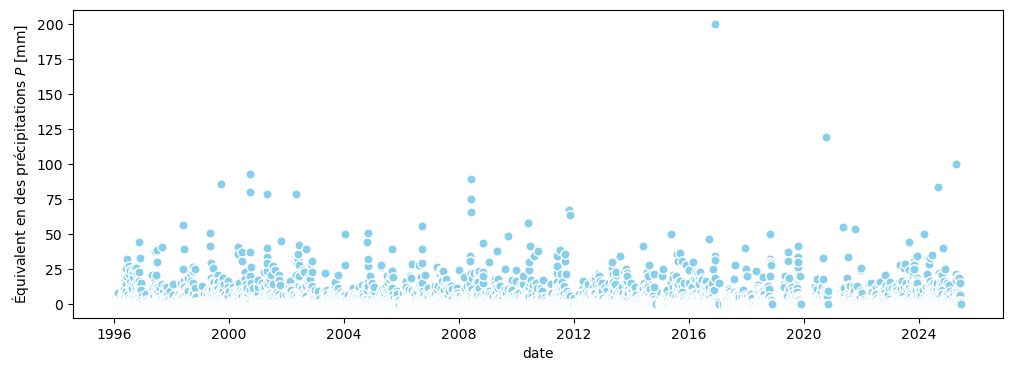

In [12]:
# distribution temporelle des distributions
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(données_pluie['date'], données_pluie["pluie"] , marker = "o",edgecolors='white', s=45, color='skyblue', alpha = 1)
ax.set_ylabel(r'Équivalent en des précipitations $P$ [mm]')
ax.set_xlabel(r'date')
max_pluie = np.nanmax(données_pluie['pluie'])
date_max = données_pluie[données_pluie['pluie']==max_pluie]['date']

Le maximum a été atteint le 24/11/2016 avec un cumul journalier de 200.0 mm.


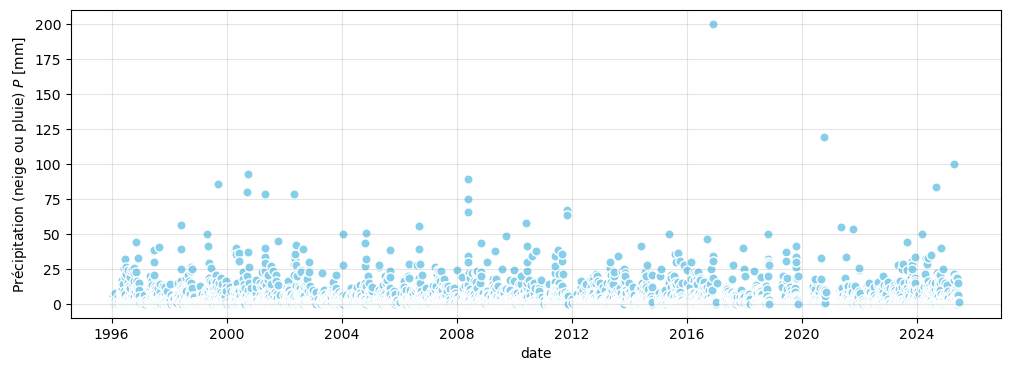

In [13]:
# distribution temporelle des distributions
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(données_pluie[données_pluie["pluie"]>0]['date'], données_pluie[données_pluie["pluie"]>0]["pluie"] ,  marker = "o",edgecolors='white', s=45, color='skyblue', alpha = 1)
ax.set_ylabel(r'Précipitation (neige ou pluie) $P$ [mm]')
ax.set_xlabel(r'date')
max_pluie = np.nanmax(données_pluie['pluie'])
date_max = données_pluie[données_pluie['pluie']==max_pluie]['date']
if  len(données_pluie[données_pluie['pluie']==max_pluie].index)>1:
      date_max =  données_pluie[données_pluie['pluie']==max_pluie]['date'].first
      date_max = str((données_pluie[données_pluie['pluie']==max_pluie]['date'].values )[0])[:-10]
      print("Le maximum a été reporté deux fois.")
else:
      date_max = données_pluie[données_pluie['pluie']==max_pluie]['date'].to_string(index = False)
if len(date_max)==10:
      date_max = datetime.datetime.strptime(date_max ,"%Y-%m-%d").strftime("%d/%m/%Y")
else:
      date_max = datetime.datetime.strptime(date_max ,"%Y-%m-%dT%S:%M:%H").strftime("%d/%m/%Y")
print("Le maximum a été atteint le "+date_max+" avec un cumul journalier de {:.1f} mm.".format(max_pluie))   
plt.grid(True, color = 'gray', alpha=0.2)


In [14]:
nom_figure="Cumul_précipitations(RR)_"+nom_poste+"("+poste_choisi+").pdf"
nom_figure=nom_figure.replace(" ", "_")
#fig.savefig(nom_figure,bbox_inches='tight')
fig.savefig(nom_figure[:-4]+'.png',bbox_inches='tight',dpi=300)

(données_pluie[['date','pluie']].fillna(value=0)).to_csv('données_pluie.csv', sep='\t', encoding='utf-8',index = False)

### Évolution

Année de début avec données complètes sur toute l'année :  1996
Le cumul annuel de précipitations est 711 mm (durant la période d'ouverture du poste).


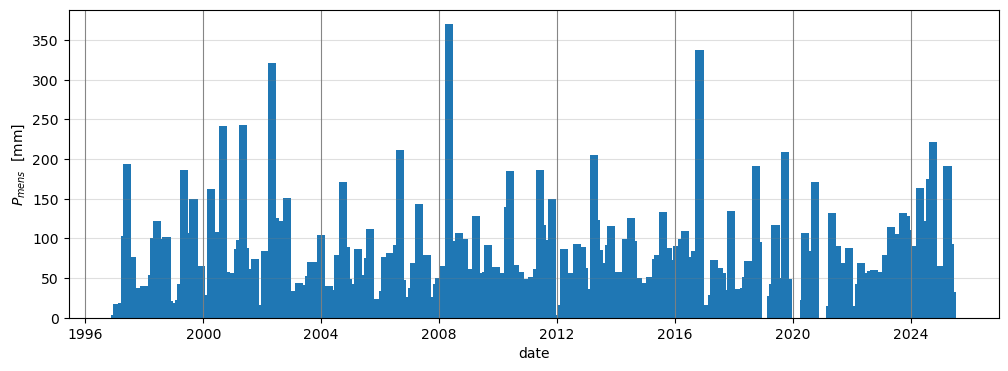

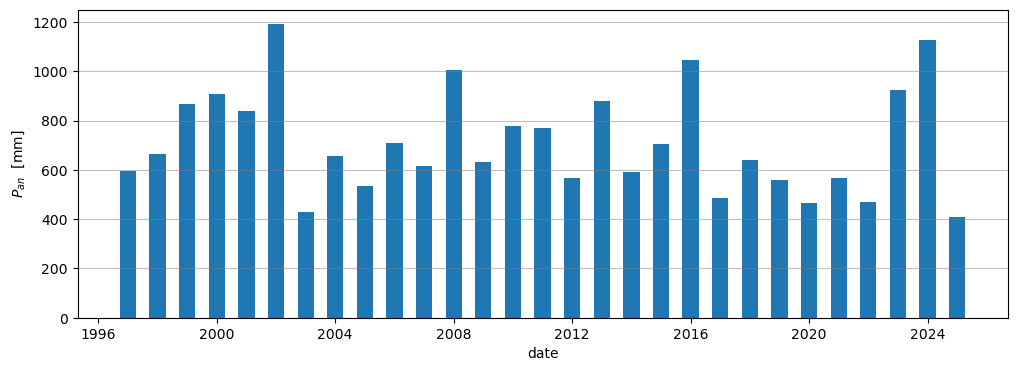

In [18]:
# évolution des cumuls mensuels et annuels

cumul_mensuel = données_pluie.groupby(by = [données_pluie['date'].dt.month, données_pluie['date'].dt.year])['pluie'].sum() 
dates_cum     = (données_pluie.groupby(by = [données_pluie['date'].dt.month, données_pluie['date'].dt.year]).first())['date']

cumul_annuel  = ((données_pluie.groupby(by = [données_pluie['date'].dt.year]))['pluie'].sum())
dates_an      = (données_pluie.groupby(by = [données_pluie['date'].dt.year]).first())['date']
# Ajuste l'année de départ
véritable_année_début = dates_an[(cumul_annuel>0) & (dates_an.dt.month == 1)].first_valid_index()
print("Année de début avec données complètes sur toute l'année : ", véritable_année_début)
cumul_mensuel = cumul_mensuel[dates_cum.dt.year>véritable_année_début]
dates_cum     = dates_cum[dates_cum.dt.year>véritable_année_début]

cumul_annuel  = cumul_annuel[dates_an.dt.year>véritable_année_début]
dates_an      = dates_an[dates_an.dt.year>véritable_année_début]

#cumul mensuel de précipitation
fig, axs = plt.subplots(figsize=(12, 4))

plt.grid(axis='y', color='gray', alpha=0.25) 
plt.grid(axis='x', color='gray', alpha=0.95)
axs.bar(dates_cum,cumul_mensuel,width=100)
axs.set_ylabel(r'$P_{mens}$  [mm]')
axs.set_xlabel(r'date')
 

nom_figure="Evolution_cumul_mensuel_precipitations_poste_"+nom_commune+"(" +poste_choisi+").pdf"
nom_figure=nom_figure.replace(" ", "_")
fig.savefig(nom_figure,bbox_inches='tight')

#cumul annuel de précipitation
fig, axs = plt.subplots(figsize=(12, 4))
plt.grid(axis='y', color='gray', alpha = 0.5)
axs.bar(dates_an,cumul_annuel,width=200)

axs.set_ylabel(r'$P_{an}$  [mm]')
axs.set_xlabel(r'date')
 

print("Le cumul annuel de précipitations est {:.0f} mm (durant la période d'ouverture du poste).".format(cumul_annuel.mean()))

nom_figure="Evolution_cumul_annuel_precipitations_poste_"+nom_commune+"(" +poste_choisi+").pdf"
nom_figure=nom_figure.replace(" ", "_")
fig.savefig(nom_figure,bbox_inches='tight')


In [19]:

display(cumul_mensuel)


date  date
1     1997      3.2
      1998     39.4
      1999     17.8
      2000      1.6
      2001     56.2
              ...  
12    2020      0.0
      2021     87.8
      2022     58.1
      2023    110.7
      2024     45.6
Name: pluie, Length: 339, dtype: float64

In [20]:
cumul_annuel_max = np.nanmax(np.delete(cumul_annuel,-1))
cumul_annuel_min = np.nanmin(np.delete(cumul_annuel,-1))
cumul_annuel_moy = np.nanmean(np.delete(cumul_annuel,-1))
print(f"Le cumul maximal est {int(cumul_annuel_max)} cm et a été observé en {np.array(cumul_annuel[cumul_annuel==cumul_annuel_max].index )[0]}.")
print(f"Le cumul minimal est {int(cumul_annuel_min)} cm et a été observé en {np.array(cumul_annuel[cumul_annuel==cumul_annuel_min].index )[0]}.")
print(f"Le cumul moyen est {int(cumul_annuel_moy)} cm.")

Le cumul maximal est 1189 cm et a été observé en 2002.
Le cumul minimal est 429 cm et a été observé en 2003.
Le cumul moyen est 721 cm.


In [27]:
np.array(cumul_annuel)


array([219. ,  99.7, 230. , 352.7, 204. , 321.8, 260.1, 177.5, 356. ,
       264.6, 243.7, 261.5, 241.1, 350.9, 222.6, 114.1, 223.5, 281.7,
       256.6, 223.1, 352. , 295. , 448.4, 231.1, 202.8, 265.4, 202.8,
       387.6, 484.3, 173.8])

In [28]:
np.array(dates_an.dt.year)

array([1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025], dtype=int32)

Le cumul mensuel de précipitations est de 43 mm
Le cumul annuel de précipitations est de 304 mm


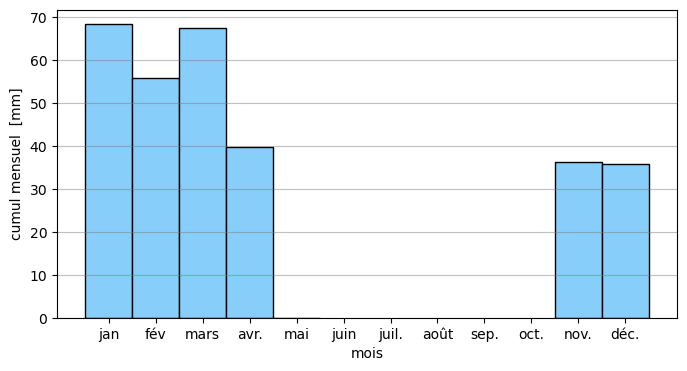

In [29]:
# distribution des cumuls mensuels de précipitation au cours d'une année

moyenne_cumul_mensuel = cumul_mensuel.groupby(by = [cumul_mensuel.index.get_level_values(0)]).mean()

# si tous les mois ne sont renseignés, met des zéros
mois_numérique = np.arange(1,12,1)
différence     = np.setdiff1d(mois_numérique,np.array(moyenne_cumul_mensuel.index.get_level_values(0)))
if np.setdiff1d(mois_numérique,différence).size != 0:
      for mois in différence:
            moyenne_cumul_mensuel.loc[mois]=np.nan
moyenne_cumul_mensuel = moyenne_cumul_mensuel.sort_index(ascending=True)

#cumul annuel de précipitation
fig, axs = plt.subplots(figsize=(8, 4))
plt.grid(axis='y', color='gray', alpha = 0.5)
axs.bar(1+np.arange(12),moyenne_cumul_mensuel,width=1,color='lightskyblue',edgecolor = 'k')

axs.set_ylabel(r'cumul mensuel  [mm]')
axs.set_xlabel(r'mois')
axs.set_xticks(1+np.arange(12), ['jan', 'fév', 'mars','avr.','mai','juin','juil.','août', 'sep.', 'oct.' , 'nov.' ,'déc.'])
 
nom_figure="Distribution_cumul_mensuel_precipitations_poste_"+nom_commune+"(" +poste_choisi+").pdf"
nom_figure=nom_figure.replace(" ", "_")
fig.savefig(nom_figure,bbox_inches='tight')
fig.savefig(nom_figure[:-4]+'.png',bbox_inches='tight',dpi=300)
print("Le cumul mensuel de précipitations est de {:.0f} mm".format(moyenne_cumul_mensuel.mean()))
print("Le cumul annuel de précipitations est de {:.0f} mm".format(moyenne_cumul_mensuel.sum()))

### Analyse des valeurs extrêmes

/home/ancey/anaconda3/envs/python3.12/lib/python3.12/site-packages/pyextremes/eva.py:131: RuntimeWarning: 119 Null values found in `data` - removing invalid entries
  warnings.warn(message=message, category=RuntimeWarning)


                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                          None      Size:                               3,535
Start:                      December 1994      End:                           April 2025
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 31      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

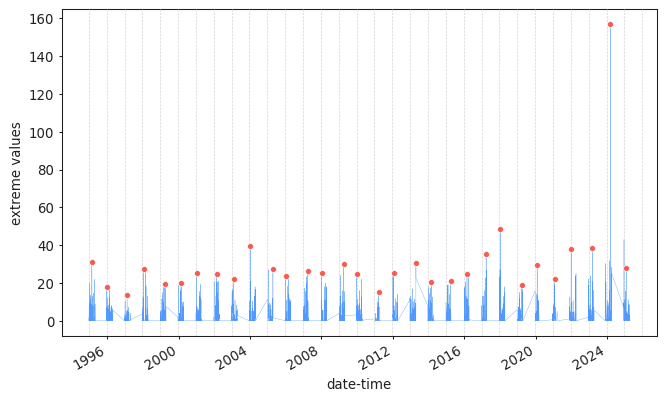

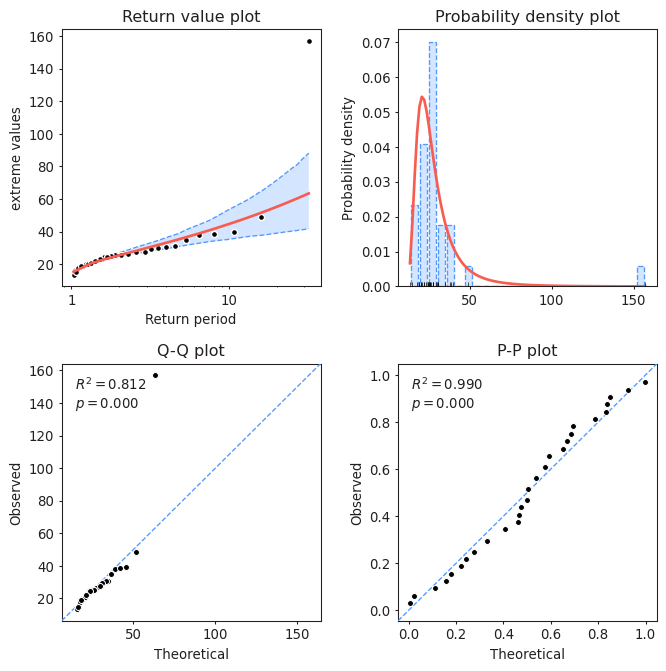

In [30]:
# ******************** EVA ********************************

# Analyse des valeurs extrêmes
série_pluie = pd.Series(np.array(données_pluie['pluie']),index=np.array(données_pluie['date'])).squeeze()
#série_pluie.fillna(method='ffill', inplace=True)

somme_annuelle        = série_pluie.resample('YE').sum()
nombre_années_nulles  = somme_annuelle[somme_annuelle==0].size
if nombre_années_nulles>0:
    dernière_année_mesure = int(str(données_pluie['date'].values[-1] )[0:4])
    dernière_année_nulle  = somme_annuelle[somme_annuelle==0].index[-1]
    if dernière_année_nulle.year == 2021:
        série2 = série_pluie[série_pluie.index<dernière_année_nulle]
        print(colored("Je suspecte qu'à cause de la covid, l'année 2021 est incomplète. Je m'arrête en 2020", 'red')
           )
    else:
        if nombre_années_nulles == 1:
            print("Il y a en tout une année nulle.") 
            print("Il faut commencer à partir de {:d} !".format(dernière_année_nulle.year+1))
            série2 = série_pluie[série_pluie.index>dernière_année_nulle]
            
        elif nombre_années_nulles > 1:
            série2 = série_pluie[série_pluie.index>dernière_année_nulle]
            print("Il y a en tout {:d} années nulles. Il faut commencer à partir de {:d} !"
              .format(nombre_années_nulles, dernière_année_nulle.year+1))    
            print(colored("J'ai pris une période plus courte",'red'))

else:
            série2 = série_pluie  
     
model = EVA(série2)
model.get_extremes(
    method="BM",
    extremes_type="high",
    block_size="365.2425D",
    errors="raise",
)
model.plot_extremes()

model.fit_model()
model.plot_diagnostic(alpha=0.7)
model


Text(0, 0.5, '$P$ [mm]')

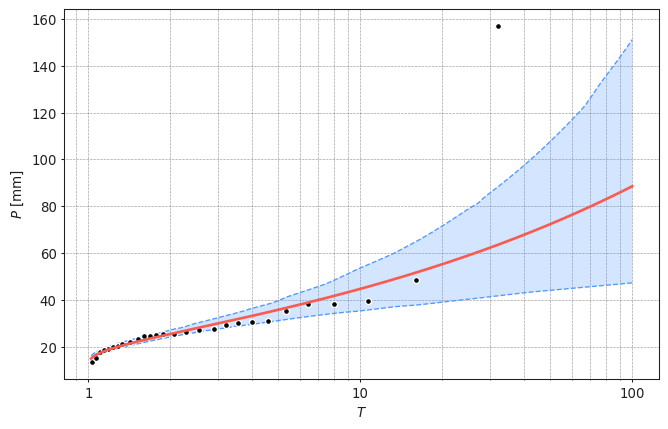

In [31]:
fig, axes = model.plot_return_values(
    return_period=np.logspace(0.01, 2, 200),
    return_period_size="365.2425D",
    alpha=0.7,
)
axes.set_xlabel(r"$T$")
axes.set_ylabel(r"$P$ [mm]")

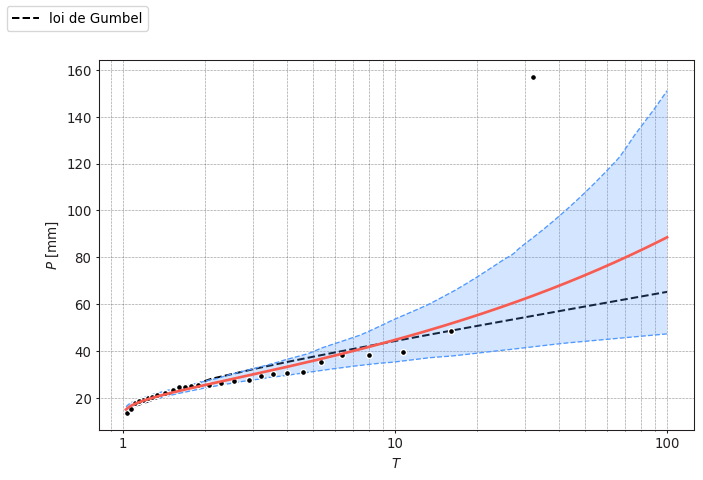

In [32]:
calage_gumbel = gumbel_r.fit(model.extremes.array)
calage_gev    = genextreme.fit(model.extremes.array)

# loi GEV
(xi, mu, sigma) = calage_gev
xi = -xi
période = np.linspace(1.1,100,100)
quantile = mu-sigma/xi*(1-(-np.log(1-1/période))**(-xi))
#axes.plot(période,quantile,'r','-',label = "loi de Fréchet")
# loi Gumbel
(mu, sigma) = calage_gumbel
période = np.linspace(1.1,100,100)
quantile = mu-sigma *np.log(-np.log(1-1/période) )
  
axes.plot(période,quantile,'--',color='black' , label = "loi de Gumbel")
fig.legend(loc="upper left")
 
nom_figure="LVE_précipitations_poste_"+nom_commune+"(" +poste_choisi+").pdf"
nom_figure=nom_figure.replace(" ", "_")
fig.savefig(nom_figure,bbox_inches='tight')
fig


In [33]:
#Estimation des quantiles
summary = model.get_summary(
    return_period=[10, 30, 100],
    alpha=0.7,
    n_samples=1000,
)
summary


return value   lower ci    upper ci
return period                                     
10.0              44.707347  35.697664   52.841544
30.0              62.288059  41.697711   83.312020
100.0             88.509221  47.656930  137.458579

## Distribution des températures

Le maximum a été atteint le 07/04/2011 avec une température de 16.0 °C.
Le minimum a été atteint le 28/12/2005 avec une température de -16.0 °C.


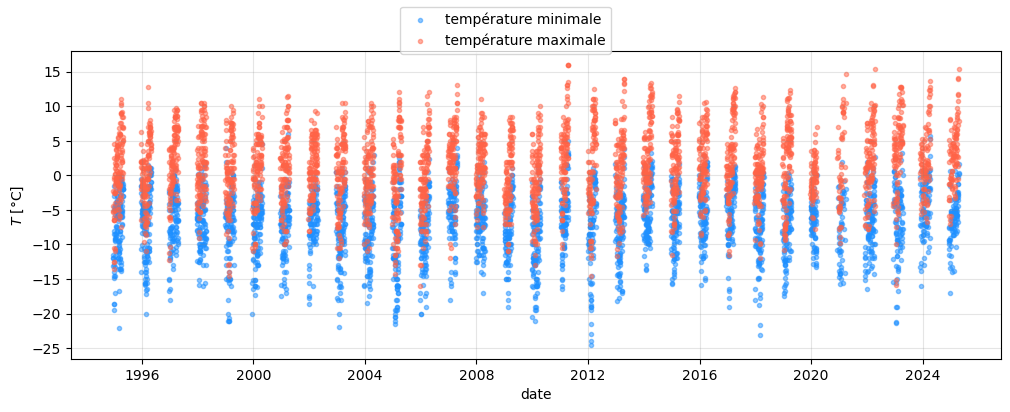

In [34]:
# distribution temporelle des température
fig, ax = plt.subplots(figsize=(12,4))

ax.set_ylabel(r'$T$ [°C]')
ax.set_xlabel(r'date')
# comme il peut y avoir plusieurs multiples on choisit la première occurrence
date_max = données_pluie[données_pluie.index  == données_pluie[données_pluie['TX']==
                                                               np.nanmax(données_pluie['TX'])].first_valid_index()]['date'].to_string(index = False)
date_min = données_pluie[données_pluie.index  == données_pluie[données_pluie['TX']==
                                                               np.nanmin(données_pluie['TX'])].first_valid_index()]['date'].to_string(index = False)
date_max = datetime.datetime.strptime(date_max ,"%Y-%m-%d").strftime("%d/%m/%Y")
date_min = datetime.datetime.strptime(date_min ,"%Y-%m-%d").strftime("%d/%m/%Y")
print("Le maximum a été atteint le "+date_max+" avec une température de {:.1f} °C.".format(np.nanmax(données_pluie["TX"]))  )
print("Le minimum a été atteint le "+date_min+" avec une température de {:.1f} °C.".format(np.nanmin(données_pluie["TX"]))  )
ax.scatter(données_pluie['date'], données_pluie["TN"] ,marker = "." ,color='dodgerblue', 
           alpha = 0.5,label = "température minimale")
ax.scatter(données_pluie['date'], données_pluie["TX"] ,marker = "." ,color='tomato', 
           alpha = 0.5,label = "température maximale")
fig.legend(loc='outside upper center')
plt.grid(True, color = 'gray', alpha=0.2)

On observe un accroissement de température de 4.8 °C par siècle.


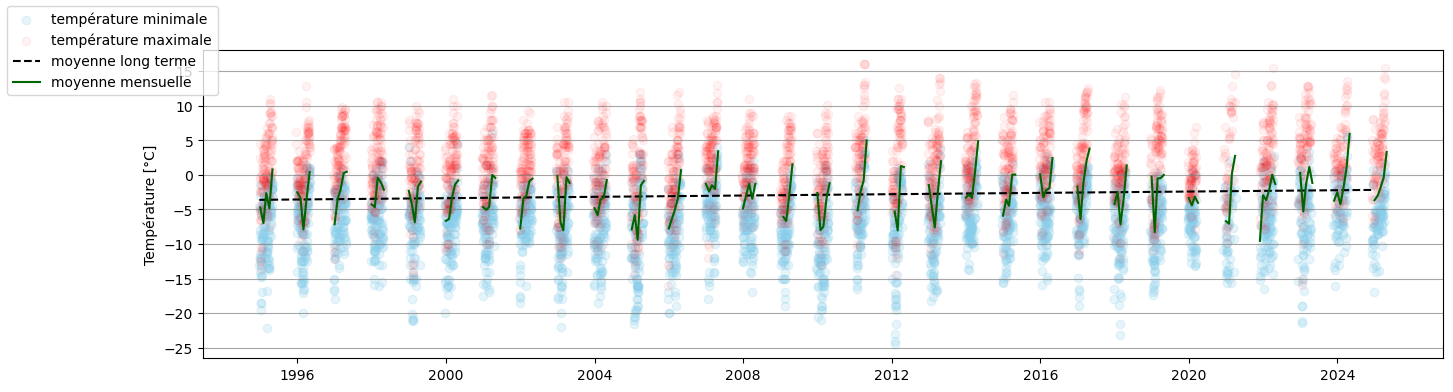

In [35]:
# parfois la série TM commence après TN et TX:
if np.isnan(données_pluie["TM"].values [0]): données_pluie["TM"] = (données_pluie["TX"]+données_pluie["TN"])/2
série_température = pd.Series(np.array(données_pluie["TM"]),index=np.array(données_pluie["date"])).squeeze()
série_température.resample('ME').mean()

température_annuelle  = np.array(données_pluie.groupby(by = [données_pluie['date'].dt.year])['TM'].mean())
dates_température     = données_pluie.groupby(by = [données_pluie['date'].dt.year])['date'].first()
dates_température_an  = np.array(dates_température.dt.year)
filtre = ~np.isnan(température_annuelle) # enlève les valeurs NaN
slope, intercept, r_value, p_value, std_err = stats.linregress(dates_température_an[filtre], température_annuelle[filtre])
trendline = intercept + slope*dates_température_an[filtre]

fig, axs = plt.subplots(figsize=(16, 4))
axs.scatter(données_pluie["date"],données_pluie["TN"],color = "skyblue", alpha = 0.2, label = "température minimale")
axs.scatter(données_pluie["date"],données_pluie["TX"],color = "red", alpha = 0.05, label = "température maximale")

axs.set_ylabel("Température [°C]")
axs.grid(axis='y', color='grey', alpha = 0.7)
axs.plot(dates_température[filtre], trendline, color = 'black', linestyle='dashed', label = "moyenne long terme")


axs.plot(série_température.resample('ME').mean(), color = 'darkgreen', label = "moyenne mensuelle")
fig.legend(loc = "outside upper left")

nom_figure="Evolution_température_poste_"+nom_commune+"(" +poste_choisi+").pdf"
nom_figure=nom_figure.replace(" ", "_")
#fig.savefig(nom_figure,bbox_inches='tight')
fig.savefig(nom_figure[:-4]+'.png',bbox_inches='tight',dpi=300)
print("On observe un accroissement de température de {:.1f} °C par siècle.".format(100*slope))



/tmp/ipykernel_6397/2490312597.py:12: RuntimeWarning: Mean of empty slice
  moyenne_température.append(np.nanmean(valT[jour_civil == i] ))


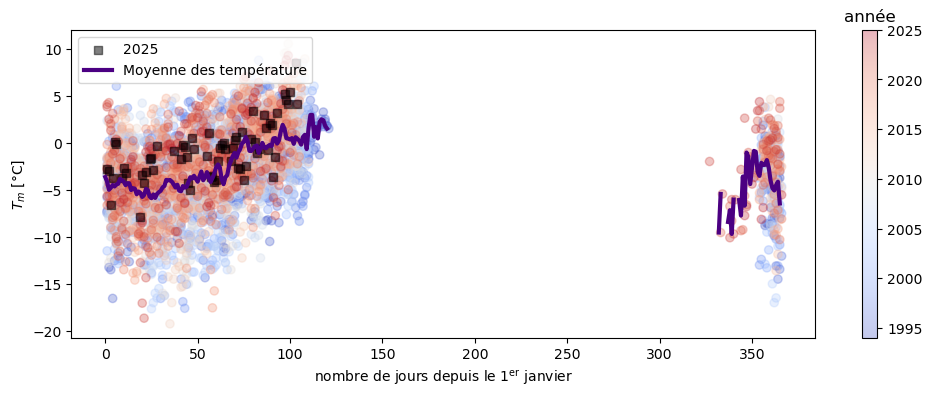

In [36]:
# Evolution moyenne de la température au fil de la saison
jour_civil = np.array(données_pluie['date'].dt.dayofyear)

année_référence = 2025
jour_civil_référence  = np.array(données_pluie[données_pluie['date'].dt.year == année_référence]['date'].dt.dayofyear)
température_référence = np.array(données_pluie[données_pluie['date'].dt.year == année_référence]['TM'])


valT = np.array(données_pluie["TM"])
moyenne_température = []
for i in range(1,367):
    moyenne_température.append(np.nanmean(valT[jour_civil == i] ))  

fig, axs = plt.subplots(figsize=(12, 4))
diag_TM = axs.scatter(jour_civil,valT, alpha = 0.3, c=np.array(données_pluie['date'].dt.year),cmap = 'coolwarm')
axs.scatter(jour_civil_référence,température_référence, alpha = 0.5, marker = "s", color = "black", label = str(année_référence) )
axs.plot(moyenne_température,color = "indigo", linewidth=3.0, label = "Moyenne des température")
cbar = fig.colorbar(diag_TM)
cbar.ax.set_title('année', rotation=0)
axs.set_ylabel(r'$T_m$ [°C]')
axs.set_xlabel(r'nombre')
axs.set_xlabel(r'nombre de jours depuis le $1^{\mathrm{er}}$ janvier')
axs.legend(loc='upper left')

nom_figure="Evolution_saisonnière_Température_poste_"+nom_commune+"(" +poste_choisi+").pdf"
nom_figure=nom_figure.replace(" ", "_")
#fig.savefig(nom_figure,bbox_inches='tight')
fig.savefig(nom_figure[:-4]+'.png',bbox_inches='tight',dpi=300)


## Neige

In [37]:
if existe_neige:
      # Nettoyage du fichier en enlevant les valeurs NaN
      données_neige = données_neige[données_neige['date']>=date_début]

      #données_neige.set_index('date', inplace=True)
      #données_neige.fillna(method='ffill', inplace=True)
      #données_neige.fillna(value=0, inplace=True)
      données_neige.info()
else: 
      print("Pas de données relatives aux chutes journalières de neige...")

<class 'pandas.core.frame.DataFrame'>
Index: 3681 entries, 553100 to 12200
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3681 non-null   datetime64[ns]
 1   neige   3599 non-null   float64       
 2   HN      3593 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 115.0 KB


In [38]:
# export au format CVS
(données_neige[['date','neige']].fillna(value=0)).to_csv('données_neige.csv', sep='\t', encoding='utf-8',index = False)
(données_neige[['date','HN']].fillna(value=0)).to_csv('données_manteau.csv', sep='\t', encoding='utf-8',index = False)

Le maximum a été atteint le 07/01/2018 avec un cumul journalier de 61.0 cm.


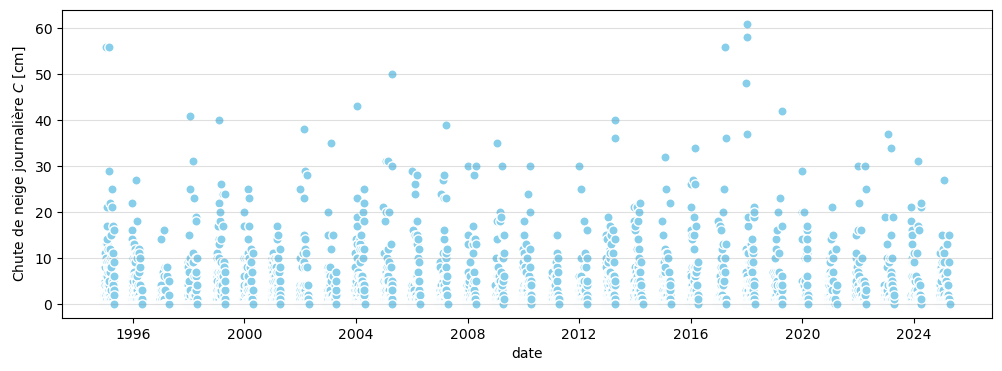

In [39]:
if existe_neige:
      # distribution temporelle des distributions
      fig, ax = plt.subplots(figsize=(12,4))
      ax.scatter(données_neige['date'], données_neige["neige"] ,  marker = "o",edgecolors='white', s=45, color='skyblue', alpha = 1)
      ax.set_ylabel(r'Chute de neige journalière $C$ [cm]')
      ax.set_xlabel(r'date')
      plt.grid(axis="y", color = 'gray', alpha = 0.25)
      date_max = données_neige[données_neige['neige']==np.nanmax(données_neige['neige'])]['date']
      if len(date_max )>1:
            date_max = datetime.datetime.strptime(str(date_max.values [0]) ,"%Y-%m-%dT%H:%M:%S.000000000").strftime("%d/%m/%Y")
            print(colored("Le maximum a été plus d'une fois !",'red')) 
      else:
            date_max = pd.Timestamp(date_max.values[0]).strftime('%d/%m/%Y')
      #date_max = datetime.datetime.strptime(date_max ,"%Y-%m-%d").strftime("%d/%m/%Y")
      print("Le maximum a été atteint le "+date_max+" avec un cumul journalier de {:.1f} cm.".format(np.nanmax(données_neige["neige"]))  )

      nom_figure="Evolution_annuelle_Chute_poste_"+nom_commune+"(" +poste_choisi+").pdf"
      nom_figure=nom_figure.replace(" ", "_")
      #fig.savefig(nom_figure,bbox_inches='tight')
      fig.savefig(nom_figure[:-4]+'.png',bbox_inches='tight',dpi=300)

### Évolution saisonnière

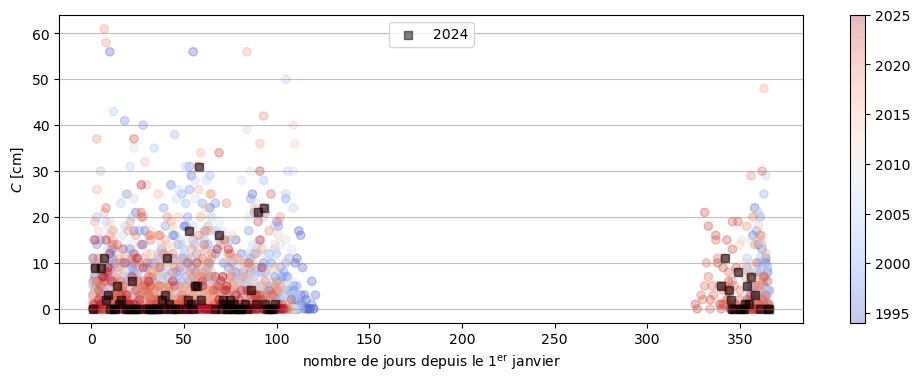

In [40]:
if existe_neige:
      jour_civil = np.array(données_neige['date'].dt.dayofyear)

      année_référence = 2024
      jour_civil_référence  = np.array(données_neige[données_neige['date'].dt.year == année_référence]['date'].dt.dayofyear)
      chute_référence = np.array(données_neige[données_neige['date'].dt.year == année_référence]['neige'])
      valN = np.array(données_neige["neige"])
 
      fig, axs = plt.subplots(figsize=(12, 4))
      diag_TN = axs.scatter(jour_civil,valN, alpha = 0.3, c=np.array(données_neige['date'].dt.year),cmap = 'coolwarm')
      axs.scatter( jour_civil_référence,chute_référence, alpha = 0.5, marker = "s", color = "black", label = str(année_référence) )
      plt.grid(axis="y", color = 'gray', alpha = 0.5)
      fig.colorbar(diag_TN)
      axs.set_ylabel(r'$C$ [cm]')
      axs.set_xlabel(r'nombre de jours depuis le $1^{\mathrm{er}}$ janvier')
      axs.legend(loc='upper center')


### Évolution au fil des ans

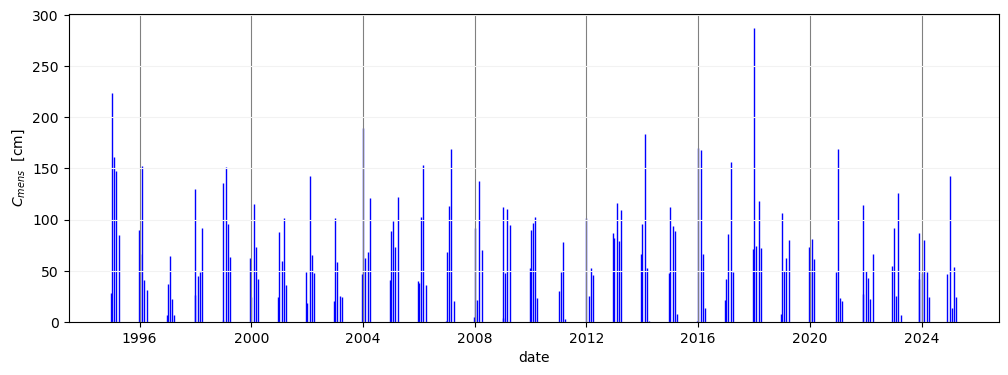

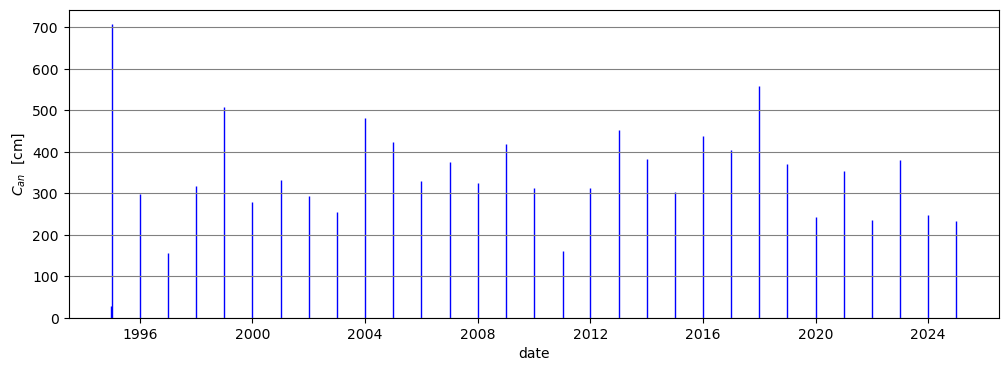

In [41]:
if existe_neige:
      cumul_mensuel = données_neige.groupby(by = [données_neige['date'].dt.month, données_neige['date'].dt.year])['neige'] .sum()
      dates_cum=données_neige.groupby(by = [données_neige['date'].dt.month, données_neige['date'].dt.year])['date'].first()

      cumul_annuel = données_neige.groupby(by = [données_neige['date'].dt.year])['neige'] .sum()
      dates_an=données_neige.groupby(by = [ données_neige['date'].dt.year])['date'].first()

      #cumul mensuel de neige
      
      fig, axs = plt.subplots(figsize=(12, 4))

      axs.bar(dates_cum.values ,cumul_mensuel.values ,width=31 ,ec='blue' )
      plt.grid(axis='y', color='0.95')
      plt.grid(axis='x', color='gray')
      axs.set_ylabel(r'$C_{mens}$  [cm]')
      axs.set_xlabel(r'date')

      nom_figure="Evolution_cumul_mensuel_poste_"+poste_choisi+".pdf"
      nom_figure=nom_figure.replace(" ", "_")
      fig.savefig(nom_figure,bbox_inches='tight')

       

      #cumul annuel de neige
      filtre = np.nonzero(cumul_annuel.values)
      fig, axs = plt.subplots(figsize=(12, 4))
      axs.bar(dates_an.values[filtre],cumul_annuel.values[filtre],ec='blue')
      plt.grid(axis='y', color='0.5')
      axs.set_ylabel(r'$C_{an}$  [cm]')
      axs.set_xlabel(r'date')

      nom_figure="Evolution_cumul_annuel_"+nom_commune+"("+poste_choisi+").pdf"
      nom_figure=nom_figure.replace(" ", "_")
      fig.savefig(nom_figure,bbox_inches='tight')

       

In [42]:
cumul_annuel_max = np.nanmax(cumul_annuel)
cumul_annuel_min = np.nanmin(np.delete(cumul_annuel,0))
cumul_annuel_moy = np.nanmean(np.delete(cumul_annuel,[0,-1]))
print(f"Le cumul annuel maximal est {int(cumul_annuel_max)} cm et a été observé en {np.array(cumul_annuel[cumul_annuel==cumul_annuel_max].index )[0]}.")
print(f"Le cumul annuel minimal est {int(cumul_annuel_min)} cm et a été observé en {np.array(cumul_annuel[cumul_annuel==cumul_annuel_min].index )[0]}.")
print(f"Le cumul annuel moyen est {int(cumul_annuel_moy)} cm.")

cumul_mensuel_max = np.nanmax(cumul_mensuel)
cumul_mensuel_min = np.nanmin(cumul_mensuel[cumul_mensuel>0])
cumul_mensuel_moy = np.nanmean(cumul_mensuel)
print(f"Le cumul mensuel maximal est {int(cumul_mensuel_max)} cm et a été observé en {np.array(cumul_mensuel[cumul_mensuel==cumul_mensuel_max].index )[0]}.")
print(f"Le cumul mensuel minimal est {int(cumul_mensuel_min)} cm et a été observé en {np.array(cumul_mensuel[cumul_mensuel==cumul_mensuel_min].index )[0]}.")
print(f"Le cumul mensuel moyen est {int(cumul_mensuel_moy)} cm.")

Le cumul annuel maximal est 707 cm et a été observé en 1995.
Le cumul annuel minimal est 156 cm et a été observé en 1997.
Le cumul annuel moyen est 355 cm.
Le cumul mensuel maximal est 287 cm et a été observé en (1, 2018).
Le cumul mensuel minimal est 1 cm et a été observé en (4, 2014).
Le cumul mensuel moyen est 69 cm.


Le cumul annuel de chutes de neige est de 389 cm


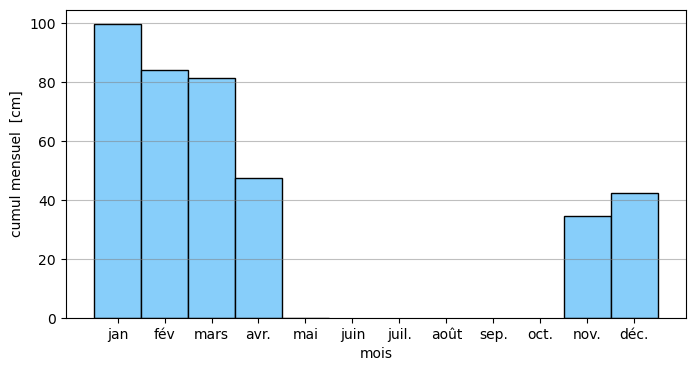

In [47]:
# distribution des cumuls mensuels de précipitation au cours d'une année

moyenne_cumul_mensuel = cumul_mensuel.groupby(by = [cumul_mensuel.index.get_level_values(0)]).mean()

# si tous les mois ne sont renseignés, met des zéros
mois_numérique = np.arange(1,12,1)
différence     = np.setdiff1d(mois_numérique,np.array(moyenne_cumul_mensuel.index.get_level_values(0)))
if np.setdiff1d(mois_numérique,différence).size != 0:
      for mois in différence:
            moyenne_cumul_mensuel.loc[mois]=np.nan
moyenne_cumul_mensuel = moyenne_cumul_mensuel.sort_index(ascending=True)

#cumul annuel de précipitation
fig, axs = plt.subplots(figsize=(8, 4))
plt.grid(axis='y', color='gray', alpha = 0.5)
axs.bar(1+np.arange(12),moyenne_cumul_mensuel,width=1,color='lightskyblue',edgecolor = 'k')

axs.set_ylabel(r'cumul mensuel  [cm]')
axs.set_xlabel(r'mois')
axs.set_xticks(1+np.arange(12), ['jan', 'fév', 'mars','avr.','mai','juin','juil.','août', 'sep.', 'oct.' , 'nov.' ,'déc.'])


nom_figure="Distribution_cumul_mensuel_precipitations_poste_"+nom_commune+"(" +poste_choisi+").pdf"
nom_figure=nom_figure.replace(" ", "_")
fig.savefig(nom_figure,bbox_inches='tight')

print("Le cumul annuel de chutes de neige est de {:.0f} cm".format(moyenne_cumul_mensuel.sum()))

### Valeurs extrêmes

/home/ancey/anaconda3/envs/python3.12/lib/python3.12/site-packages/pyextremes/eva.py:131: RuntimeWarning: 73 Null values found in `data` - removing invalid entries
  warnings.warn(message=message, category=RuntimeWarning)


                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                          None      Size:                               3,498
Start:                       January 1995      End:                        December 2024
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 30      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

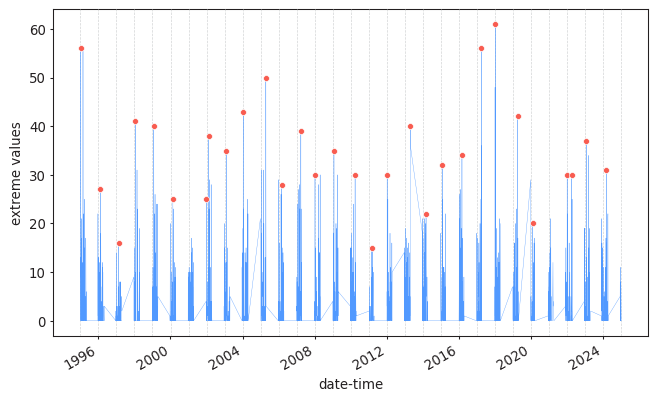

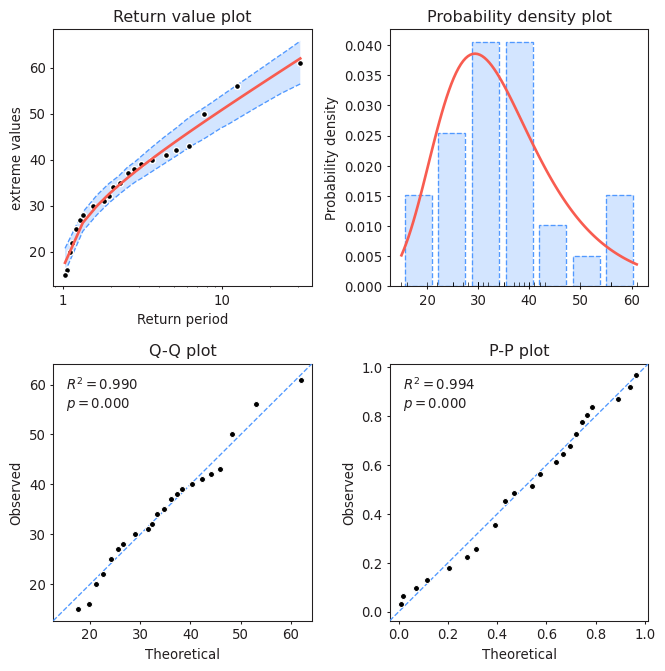

In [49]:
# Analyse des valeurs extrêmes
série_chute = pd.Series(np.array(données_neige['neige']),index=np.array(données_neige['date'])).squeeze()
# Quand il y a des années avec des valeurs nulles
série_chute2 = série_chute["1995-01-01":"2024-12-31"]
model = EVA(série_chute2)
model.get_extremes(
    method="BM",
    extremes_type="high",
    block_size="365.2425D",
    errors="raise",
)

model.plot_extremes()

model.fit_model()
model.plot_diagnostic(alpha=0.7)
model


Text(0, 0.5, '$C$ [cm]')

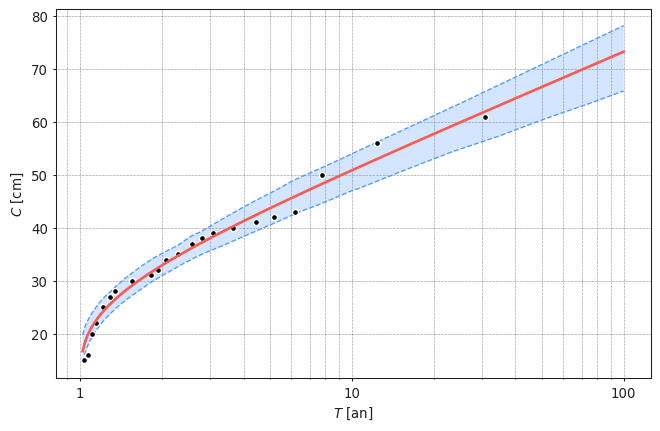

In [50]:
fig, axes = model.plot_return_values(
    return_period=np.logspace(0.01, 2, 200),
    return_period_size="365.2425D",
    alpha=0.7,
)
axes.set_xlabel(r"$T$ [an]")
axes.set_ylabel(r"$C$ [cm]")


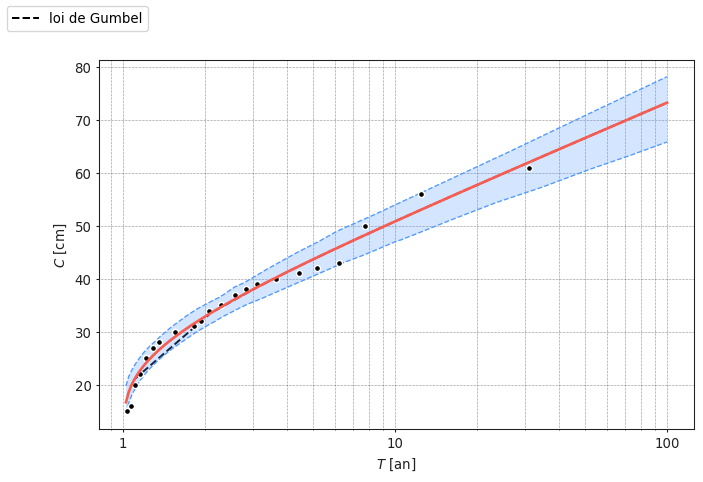

In [51]:

calage_gumbel = gumbel_r.fit(model.extremes.array)
calage_gev    = genextreme.fit(model.extremes.array)

# loi GEV
(xi, mu, sigma) = calage_gev
xi = -xi
période = np.linspace(1.1,100,100)
quantile = mu-sigma/xi*(1-(-np.log(1-1/période))**(-xi))
#axes.plot(période,quantile,'r','-',label = "loi de Fréchet")
# loi Gumbel
(mu, sigma) = calage_gumbel
période = np.linspace(1.1,100,100)
quantile = mu-sigma *np.log(-np.log(1-1/période) )
  
axes.plot(période,quantile,'--',color='black' , label = "loi de Gumbel")
fig.legend(loc="upper left")

nom_figure="LVE_chutes_poste_"+nom_commune+"(" +poste_choisi+").pdf"
nom_figure=nom_figure.replace(" ", "_")
fig.savefig(nom_figure,bbox_inches='tight')
fig


In [52]:
#Estimation des quantiles
summary = model.get_summary(
    return_period=[10, 30, 100],
    alpha=0.7,
    n_samples=1000,
)
summary


return value   lower ci   upper ci
return period                                    
10.0              50.836163  46.828850  53.928873
30.0              61.647732  56.131940  65.751549
100.0             73.240449  65.923311  78.601768

## Épaisseur du manteau neigeux

### Évolution au fil des années

In [53]:
# détermination de la série de données en cas de série discontinue

if not existe_HN:
      print(colored("Je n'ai pas de données d'épaisseur de neige !"),'red')
else:
      # J'enlève les années nulles. Il y a plusieurs possibilités
      somme_annuelle = pd.Series(np.array(données_neige["HN"]), index = np.array(données_neige["date"])).resample('YE').sum()
      nombre_années_nulles = somme_annuelle[somme_annuelle==0].size
      années_non_nulles = somme_annuelle[somme_annuelle>0].index.year
      séries_continues = trouver_période_continue(années_non_nulles)
      nombre_série_continue = len(séries_continues )
      if nombre_années_nulles == 1:
            print("Il y a en tout une année nulle.") 
            dernière_année_nulle = somme_annuelle[somme_annuelle==0].index[-1]
            print("Faudrait-il commencer à partir de {:d} ?".format(dernière_année_nulle.year+1))  
      elif nombre_années_nulles > 1: 
            dernière_année_nulle = somme_annuelle[somme_annuelle==0].index[-1]  
            print(colored("J'ai pris une période plus courte",'red'))
            print("Il y a en tout {:d} années nulles.Faut-il commencer à partir de {:d} ?".format(nombre_années_nulles, dernière_année_nulle.year+1))
      if nombre_série_continue>1:
            print(colored(f"J'ai trouvé {nombre_série_continue} séries continues en tout.",'cyan'))
            for i in range(nombre_série_continue):
                  an_début_série = séries_continues[i][0]
                  an_fin_série   = séries_continues[i][-1]
                  print(f"Série {i+1} : {an_début_série}-{an_fin_série} (soit {an_fin_série-an_début_série+1} années)")




Le maximum a été de 245.0 cm et il a été le 09/01/2018.
Le maximum a été atteint le 09/01/2018 avec une hauteur de 245 cm.


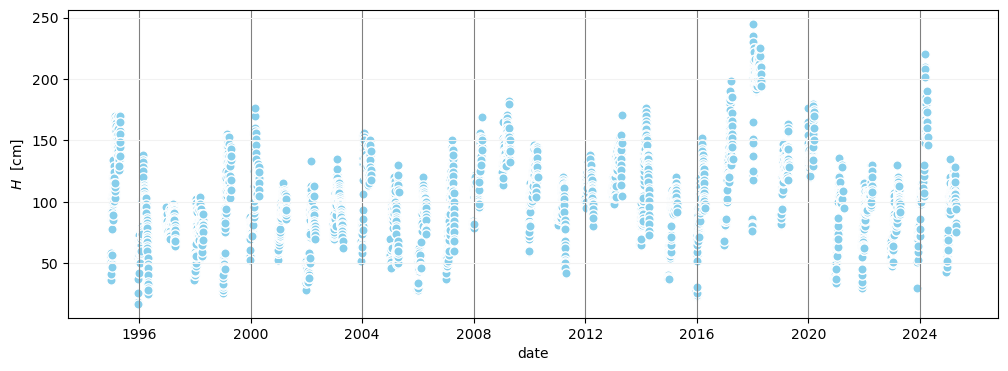

In [54]:
série_retenue = 1
date_début_série = str(séries_continues[série_retenue-1][0])+"-01-01"
date_fin_série   = str(séries_continues[série_retenue-1][-1])+"-12-31"
filtrage_date = (données_neige['date']>= date_début_série) & (données_neige['date'] <= date_fin_série)
série_HN = données_neige[filtrage_date]
# distribution temporelle des hauteurs du manteux neigeux
date_max = série_HN[série_HN['HN']==np.nanmax(série_HN['HN'])]['date']
if len(date_max )>1:
      date_max = datetime.datetime.strptime(str(date_max.values [0]) ,"%Y-%m-%dT%H:%M:%S.000000000").strftime("%d/%m/%Y")
      print(colored("Le maximum a été plus d'une fois !",'red')) 
else:
      date_max = pd.Timestamp(date_max.values[0]).strftime('%d/%m/%Y')
print(f"Le maximum a été de {np.nanmax(série_HN['HN'])} cm et il a été le {date_max}.")

if existe_HN:
      fig, axs = plt.subplots(figsize=(12, 4))
      axs.scatter(série_HN['date'],série_HN["HN"],  marker = "o",edgecolors='white', s=45, color='skyblue', alpha = 1)
      plt.grid(axis='y', color='0.95')
      plt.grid(axis='x', color='gray')
      axs.set_ylabel(r'$H$  [cm]')
      axs.set_xlabel(r'date')
      print("Le maximum a été atteint le "+date_max+" avec une hauteur de {:.0f} cm.".format(np.nanmax(données_neige["HN"]))  )

      nom_figure="Evolution_annuelle_épaisseur_poste_"+nom_commune+"(" +poste_choisi+").pdf"
      nom_figure=nom_figure.replace(" ", "_")
      #fig.savefig(nom_figure,bbox_inches='tight')
      fig.savefig(nom_figure[:-4]+'.png',bbox_inches='tight',dpi=300)
else:
      print(colored("Je n'ai pas de données à tracer",'red'))


### Évolution au fil de la saison

/tmp/ipykernel_6397/209361181.py:17: RuntimeWarning: Mean of empty slice
  moyenne_hauteur.append(np.nanmean(valH[jour_civil == i] ))
/tmp/ipykernel_6397/209361181.py:18: RuntimeWarning: All-NaN slice encountered
  min_hauteur.append(np.nanmin(valH[jour_civil == i] ))
/tmp/ipykernel_6397/209361181.py:19: RuntimeWarning: All-NaN slice encountered
  max_hauteur.append(np.nanmax(valH[jour_civil == i] ))


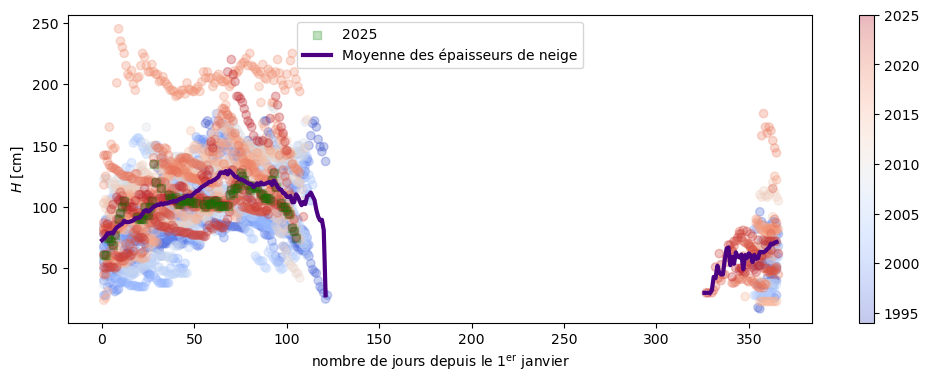

In [55]:
if existe_HN:
    jour_civil       = np.array(série_HN['date'].dt.dayofyear)

    année_référence = 2025

    jour_civil_référence = np.array(série_HN[série_HN['date'].dt.year == année_référence]['date'].dt.dayofyear)
    hauteur_référence    = np.array(série_HN[série_HN['date'].dt.year == année_référence]['HN'])
 
 

    valH = np.array(série_HN["HN"])
    moyenne_hauteur = []
    max_hauteur = []
    min_hauteur = []
    for i in range(1,367):
        if valH[jour_civil == i].size > 0:
            moyenne_hauteur.append(np.nanmean(valH[jour_civil == i] ))
            min_hauteur.append(np.nanmin(valH[jour_civil == i] ))
            max_hauteur.append(np.nanmax(valH[jour_civil == i] ))
        else:
            moyenne_hauteur.append(np.nan)
            min_hauteur.append(np.nan)
            max_hauteur.append(np.nan) 

    fig, axs = plt.subplots(figsize=(12, 4))
    diag_hauteur = axs.scatter(jour_civil,valH, alpha = 0.3, c=np.array(série_HN['date'].dt.year),cmap = 'coolwarm')
    axs.scatter(jour_civil_référence, hauteur_référence, alpha = 0.25, marker = "s", color = "green", label = str(année_référence) )
    axs.plot(moyenne_hauteur,color = "indigo", linewidth=3.0, label = "Moyenne des épaisseurs de neige")
    fig.colorbar(diag_hauteur)
    axs.set_ylabel(r'$H$ [cm]')
    axs.set_xlabel(r'nombre de jours depuis le $1^{\mathrm{er}}$ janvier')
    axs.legend(loc='upper center')
else:
    print("Pas de données relatives aux épaisseurs du manteau neigeux")

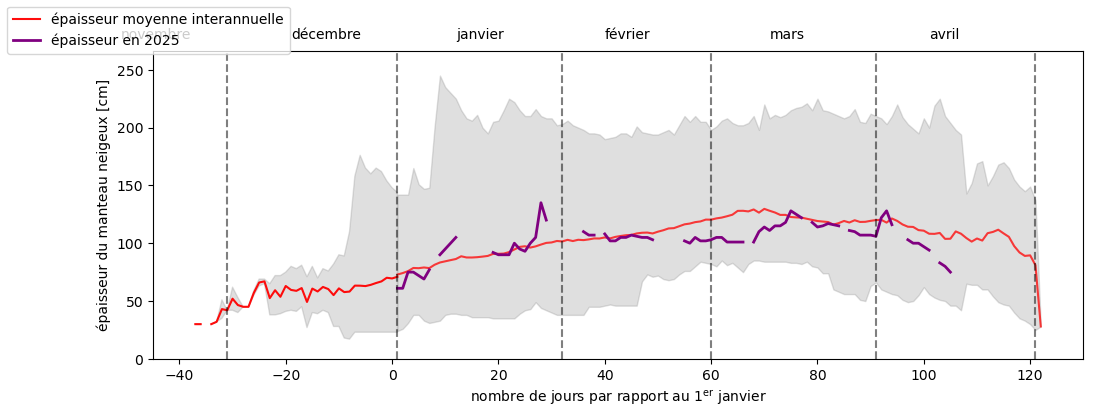

In [56]:
# évolution du manteau neigeux
date_format = "%d/%m/%Y"

début_saison = datetime.datetime.strptime('01/11/2008', date_format)
fin_année    = datetime.datetime.strptime('31/12/2008', date_format)
fin_saison   = datetime.datetime.strptime('15/05/2008', date_format)
début_année  = datetime.datetime.strptime('01/01/2008', date_format)

delta_fin    = fin_saison - début_année
delta_début  = fin_année - début_saison
jour_d       = np.array(range(366))-363
jour         = np.array(range(366))+1
fig, axs = plt.subplots(figsize=(12, 4))

axs.fill_between(jour_d[-delta_début.days:-1],max_hauteur[-delta_début.days:-1],min_hauteur[-delta_début.days:-1] , color ='gray',alpha = 0.25)
axs.fill_between(jour[0:delta_fin.days],max_hauteur[0:delta_fin.days],min_hauteur[0:delta_fin.days] , color ='gray',alpha = 0.25)

axs.plot(jour_d[-delta_début.days:-1],moyenne_hauteur[-delta_début.days:-1] , color ='red',alpha = 0.95, label = "épaisseur moyenne interannuelle")
axs.plot(jour[0:delta_fin.days],moyenne_hauteur[0:delta_fin.days] , color ='red',alpha = 0.75)

axs.plot(jour_civil_référence[0:delta_fin.days],hauteur_référence[0:delta_fin.days] , color ='purple',alpha = 1,
         linewidth = 2, label = "épaisseur en "+str(année_référence))


limite_axe_y = max(axs.get_ylim())

axs.set_ylim((0,limite_axe_y+10))
mois_nom   = ['novembre','décembre','janvier','février','mars','avril']
mois_durée = [-31,1,32,60,91,121]
#ax.axhline(y, linestyle='--', color='k') # horizontal lines
for i in range(6):
      axs.axvline(mois_durée[i], linestyle='--', color='k', alpha = 0.5) # vertical line
      axs.text(mois_durée[i]-20,limite_axe_y+20,mois_nom[i])
fig.legend(loc='outside upper left')
axs.set_ylabel(r"épaisseur du manteau neigeux [cm]")
axs.set_xlabel(r'nombre de jours par rapport au $1^{\mathrm{er}}$ janvier')


nom_figure="Evolution-saison_manteau_neigeux_"+nom_commune+"("+poste_choisi+").pdf"
nom_figure=nom_figure.replace(" ", "_")
fig.savefig(nom_figure,bbox_inches='tight')
fig.savefig(nom_figure[:-4]+'.png',bbox_inches='tight',dpi=300)


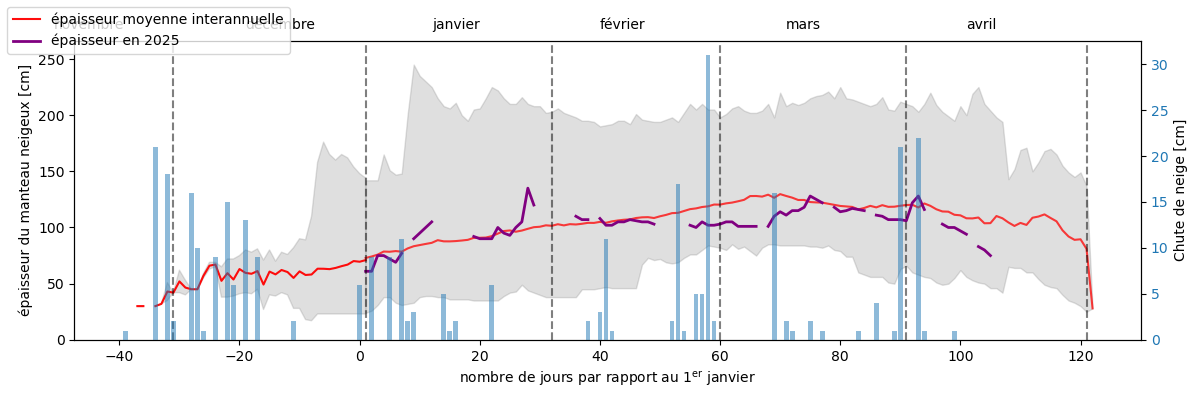

In [57]:
# Détermination des chutes de neige de la saison
année_référence = 2024
année_antérieure = '31/12/'+str(année_référence-1) 
saison_référence  = données_neige[(données_neige['date'].dt.year == année_référence )& ( données_neige['date'].dt.month <6) |
                                  (( données_neige['date'].dt.year ==année_référence-1) & ( données_neige['date'].dt.month >10) )]
chutes_référence  = np.array(saison_référence['neige'])
dates_référence  = saison_référence ['date']-datetime.datetime.strptime(année_antérieure, date_format)
dates_référence  = np.array(dates_référence .dt.days)


ax2 = axs.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Chute de neige [cm]' )   
ax2.bar(dates_référence, chutes_référence, color=color, alpha = 0.5)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  

nom_figure="Evolution_manteau_neigeux+chutes_neige_"+nom_commune+"("+poste_choisi+").pdf"
nom_figure=nom_figure.replace(" ", "_")
fig.savefig(nom_figure,bbox_inches='tight')
fig.savefig(nom_figure[:-4]+'.png',bbox_inches='tight',dpi=300)
 
fig

In [58]:
saison_Température_référence = données_pluie[(données_pluie['date'].dt.year == année_référence )|
                                             (( données_pluie['date'].dt.year ==année_référence-1) & ( données_pluie['date'].dt.month >10) )]
if all(np.array(saison_Température_référence['TM'])):
      Température_référence  = (np.array(saison_Température_référence['TX'])+np.array(saison_Température_référence['TN']))/2
else:
      Température_référence  = np.array(saison_Température_référence['TM'])

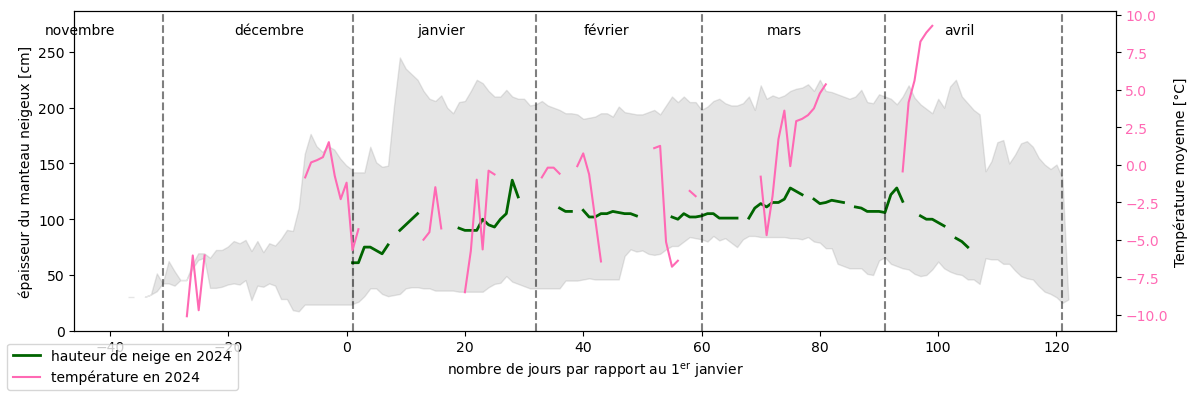

In [59]:
 # Détermination des chutes de neige de la saison
saison_Température_référence = données_pluie[(données_pluie['date'].dt.year == année_référence )& ( données_pluie['date'].dt.month <5)|
                                             (( données_pluie['date'].dt.year ==année_référence-1) & ( données_pluie['date'].dt.month >10) )]
if all(np.array(saison_Température_référence['TM'])):
      Température_référence  = (np.array(saison_Température_référence['TX'])+np.array(saison_Température_référence['TN']))/2
else:
      Température_référence  = np.array(saison_Température_référence['TM'])
saison_Température_référence  = saison_Température_référence['date']-datetime.datetime.strptime(année_antérieure, date_format)
saison_Température_référence  = np.array(saison_Température_référence.dt.days)


début_saison = datetime.datetime.strptime('01/11/2008', date_format)
fin_année    = datetime.datetime.strptime('31/12/2008', date_format)
fin_saison   = datetime.datetime.strptime('15/05/2008', date_format)
début_année  = datetime.datetime.strptime('01/01/2008', date_format)

delta_fin = fin_saison - début_année
delta_début = fin_année - début_saison
jour_d =np.array(range(366))-363
jour = np.array(range(366))+1

fig, axs = plt.subplots(figsize=(12, 4))

axs.fill_between(jour_d[-delta_début.days:-1],max_hauteur[-delta_début.days:-1],min_hauteur[-delta_début.days:-1] , color ='gray',alpha = 0.2)
axs.fill_between(jour[0:delta_fin.days],max_hauteur[0:delta_fin.days],min_hauteur[0:delta_fin.days] , color ='gray',alpha = 0.2)

axs.plot(jour_civil_référence [0:delta_fin.days],hauteur_référence [0:delta_fin.days] , color ='darkgreen',
         alpha = 1,linewidth = 2, label = "hauteur de neige en "+str(année_référence))

limite_axe_y = max(axs.get_ylim())

axs.set_ylim((0,limite_axe_y+30))

# grille des mois
mois_nom   = ['novembre','décembre','janvier','février','mars','avril']
mois_durée = [-31,1,32,60,91,121]
#ax.axhline(y, linestyle='--', color='k') # horizontal lines
for i in range(6):
      axs.axvline(mois_durée[i], linestyle='--', color='k', alpha = 0.5) # vertical line
      axs.text(mois_durée[i]-20,limite_axe_y + 10,mois_nom[i])

axs.set_ylabel(r"épaisseur du manteau neigeux [cm]")
axs.set_xlabel(r'nombre de jours par rapport au $1^{\mathrm{er}}$ janvier')

ax2 = axs.twinx()   

# tracé des températures
color = 'hotpink'
ax2.set_ylabel('Température moyenne [°C]' )   
ax2.plot(saison_Température_référence, Température_référence, color=color, alpha = 1, linewidth = 1.5, 
         label = "température en "+str(année_référence))
ax2.tick_params(axis='y', labelcolor=color)
fig.legend(loc='outside lower left')
fig.tight_layout()   
 
nom_figure="Evolution_température_poste_"+nom_commune+"(" +poste_choisi+").pdf"
nom_figure=nom_figure.replace(" ", "_")
fig.savefig(nom_figure,bbox_inches='tight')
fig.savefig(nom_figure[:-4]+'.png',bbox_inches='tight',dpi=300)

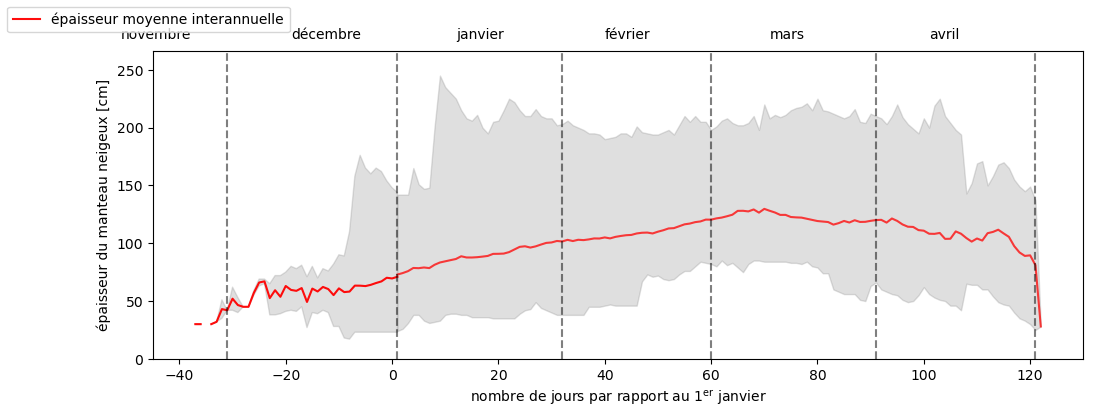

In [60]:
# manteau neigeux
# évolution du manteau neigeux
date_format = "%d/%m/%Y"

début_saison = datetime.datetime.strptime('01/11/2008', date_format)
fin_année    = datetime.datetime.strptime('31/12/2008', date_format)
fin_saison   = datetime.datetime.strptime('15/05/2008', date_format)
début_année  = datetime.datetime.strptime('01/01/2008', date_format)

delta_fin    = fin_saison - début_année
delta_début  = fin_année - début_saison
jour_d       = np.array(range(366))-363
jour         = np.array(range(366))+1
fig, axs = plt.subplots(figsize=(12, 4))

axs.fill_between(jour_d[-delta_début.days:-1],max_hauteur[-delta_début.days:-1],min_hauteur[-delta_début.days:-1] , color ='gray',alpha = 0.25)
axs.fill_between(jour[0:delta_fin.days],max_hauteur[0:delta_fin.days],min_hauteur[0:delta_fin.days] , color ='gray',alpha = 0.25)

axs.plot(jour_d[-delta_début.days:-1],moyenne_hauteur[-delta_début.days:-1] , color ='red',alpha = 0.95, label = "épaisseur moyenne interannuelle")
axs.plot(jour[0:delta_fin.days],moyenne_hauteur[0:delta_fin.days] , color ='red',alpha = 0.75)




limite_axe_y = max(axs.get_ylim())

axs.set_ylim((0,limite_axe_y+10))
mois_nom   = ['novembre','décembre','janvier','février','mars','avril']
mois_durée = [-31,1,32,60,91,121]
#ax.axhline(y, linestyle='--', color='k') # horizontal lines
for i in range(6):
      axs.axvline(mois_durée[i], linestyle='--', color='k', alpha = 0.5) # vertical line
      axs.text(mois_durée[i]-20,limite_axe_y+20,mois_nom[i])
fig.legend(loc='outside upper left')
axs.set_ylabel(r"épaisseur du manteau neigeux [cm]")
axs.set_xlabel(r'nombre de jours par rapport au $1^{\mathrm{er}}$ janvier')


nom_figure="Evolution-saison_minimax_manteau_neigeux_"+nom_commune+"("+poste_choisi+").pdf"
nom_figure=nom_figure.replace(" ", "_")
fig.savefig(nom_figure,bbox_inches='tight')
fig.savefig(nom_figure[:-4]+'.png',bbox_inches='tight',dpi=300)


### Valeurs extrêmes

/home/ancey/anaconda3/envs/python3.12/lib/python3.12/site-packages/pyextremes/eva.py:131: RuntimeWarning: 88 Null values found in `data` - removing invalid entries
  warnings.warn(message=message, category=RuntimeWarning)


Text(0, 0.5, '$H$ [cm]')

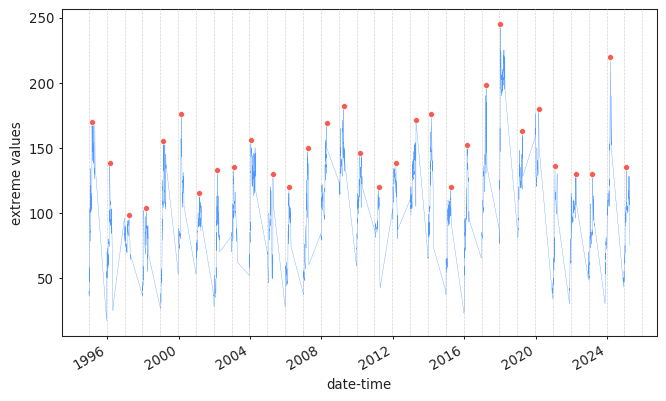

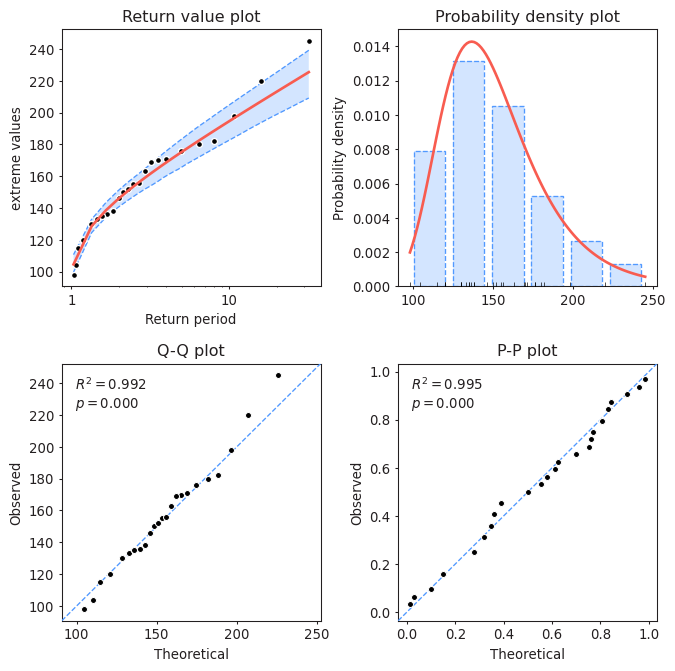

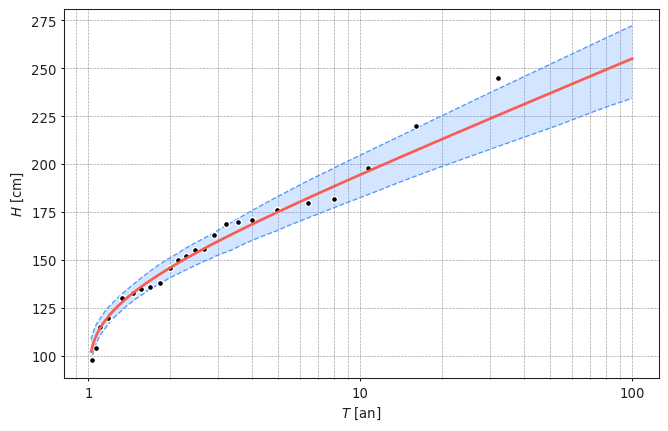

In [61]:
# Analyse des valeurs extrêmes
série_hauteur = pd.Series(np.array(série_HN['HN']),index=np.array(série_HN['date'])).squeeze()
#série_pluie.fillna(method='ffill', inplace=True)
model = EVA(série_hauteur)
model.get_extremes(
    method="BM",
    extremes_type="high",
    block_size="365.2425D",
    errors="raise",
)

model.plot_extremes()

model.fit_model()
model.plot_diagnostic(alpha=0.7)
model


fig, axes = model.plot_return_values(
    return_period=np.logspace(0.01, 2, 200),
    return_period_size="365.2425D",
    alpha=0.7,
)
axes.set_xlabel(r"$T$ [an]")
axes.set_ylabel(r"$H$ [cm]")


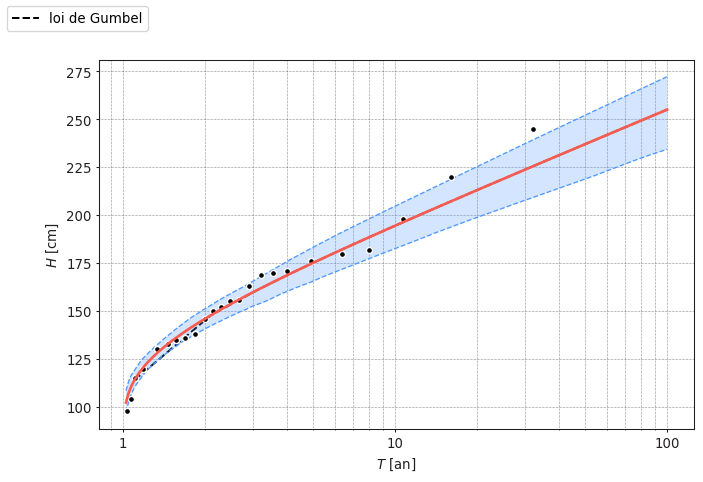

In [62]:
calage_gumbel = gumbel_r.fit(model.extremes.array)
calage_gev    = genextreme.fit(model.extremes.array)

# loi GEV
(xi, mu, sigma) = calage_gev
xi = -xi
période = np.linspace(1.1,100,100)
quantile = mu-sigma/xi*(1-(-np.log(1-1/période))**(-xi))
#axes.plot(période,quantile,'r','-',label = "loi de Fréchet")
# loi Gumbel
(mu, sigma) = calage_gumbel
période = np.linspace(1.1,100,100)
quantile = mu-sigma *np.log(-np.log(1-1/période) )
  
axes.plot(période,quantile,'--',color='black' , label = "loi de Gumbel")
fig.legend(loc="upper left")
fig.savefig("LVE_Epaisseur_poste_"+nom_commune+"(" +poste_choisi+").pdf",bbox_inches='tight')
fig

In [63]:
#Estimation des quantiles
summary = model.get_summary(
    return_period=[10, 30, 100],
    alpha=0.7,
    n_samples=1000,
)
summary

return value    lower ci    upper ci
return period                                      
10.0             194.552269  182.359914  204.205730
30.0             223.767168  207.599419  236.791724
100.0            255.092878  233.984797  271.641904

In [64]:
model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                          None      Size:                               3,593
Start:                      December 1994      End:                           April 2025
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 31      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

## Chutes de neige sur trois jours

In [65]:
# chutes journalières
série_chute = pd.Series(np.array(données_neige['neige']),index=np.array(données_neige['date'])).squeeze()
# J'enlève les années nulles. Il y a plusieurs possibilités
somme_annuelle = pd.Series(np.array(série_chute), index = np.array(série_chute.index)).resample('YE').sum()
nombre_années_nulles = somme_annuelle[somme_annuelle==0].size
années_non_nulles = somme_annuelle[somme_annuelle>0].index.year
séries_continues = trouver_période_continue(années_non_nulles)
nombre_série_continue = len(séries_continues )
if nombre_série_continue>1:
      print(colored(f"J'ai trouvé {nombre_série_continue} séries continues en tout.",'cyan'))
      for i in range(nombre_série_continue):
            an_début_série = séries_continues[i][0]
            an_fin_série   = séries_continues[i][-1]
            print(f"Série {i+1} : {an_début_série}-{an_fin_série} (soit {an_fin_série-an_début_série+1} années)")
if nombre_série_continue==1:
            print(colored(f"J'ai trouvé une seule série continues en tout.",'cyan'))
            an_début_série = séries_continues[0][0]
            an_fin_série   = séries_continues[0][-1]
            print(f"Série continue : {an_début_série}-{an_fin_série} (soit {an_fin_série-an_début_série+1} années)")

J'ai trouvé une seule série continues en tout.
Série continue : 1994-2025 (soit 32 années)


In [66]:
série_retenue = 1
date_début_série = str(séries_continues[série_retenue-1][0])+"-01-01"
date_fin_série   = str(séries_continues[série_retenue-1][-1])+"-12-31"
filtrage_date = (série_chute.index>= date_début_série) & (série_chute.index <= date_fin_série)
série_3 = série_chute[filtrage_date]
# distribution temporelle des hauteurs du manteux neigeux
date_max = série_3[série_3==np.nanmax(série_3)].index
if len(date_max )>1:
      print(colored("Le maximum a été plus d'une fois !",'red')) 

date_max = datetime.datetime.strptime(str(date_max.values [0]) ,"%Y-%m-%dT%H:%M:%S.000000000").strftime("%d/%m/%Y")
print(f"Le maximum a été de {np.nanmax(série_3)} cm et il a été le {date_max}.")

Le maximum a été de 61.0 cm et il a été le 07/01/2018.


In [67]:
série_trois_jours = série_3.rolling(3, win_type='boxcar', center=True).sum()

date_max = série_trois_jours[série_trois_jours==np.nanmax(série_trois_jours)].index[0]
date_max = datetime.datetime.strptime(str(date_max) ,"%Y-%m-%d %H:%M:%S").strftime("%d/%m/%Y")
print("Le cumul maximum sur trois jours a été de {:d} cm et il s'est produit le {:s}."
      .format(int(np.nanmax(série_trois_jours)),date_max))


Le cumul maximum sur trois jours a été de 124 cm et il s'est produit le 07/01/2018.


### EVA

/home/ancey/anaconda3/envs/python3.12/lib/python3.12/site-packages/pyextremes/eva.py:131: RuntimeWarning: 218 Null values found in `data` - removing invalid entries
  warnings.warn(message=message, category=RuntimeWarning)


Text(0, 0.5, '$C_3$ [cm]')

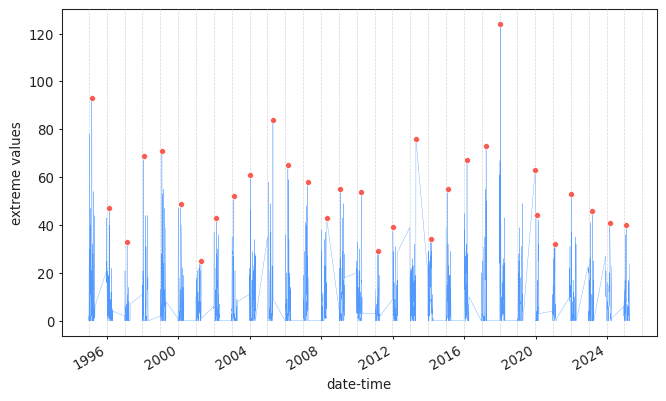

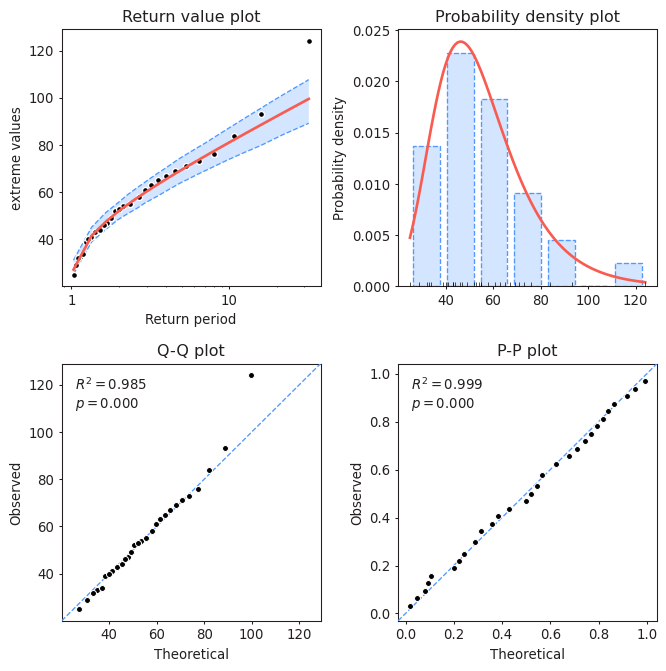

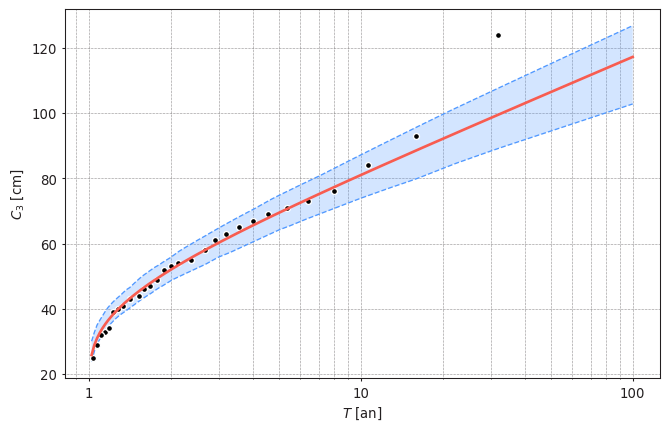

In [68]:
#  ****************** EVA ****************** 

# Analyse des valeurs extrêmes
 
#série_pluie.fillna(method='ffill', inplace=True)
model = EVA(série_trois_jours)
model.get_extremes(
    method="BM",
    extremes_type="high",
    block_size="365.2425D",
    errors="raise",
)

model.plot_extremes()

model.fit_model()
model.plot_diagnostic(alpha=0.7)
model


fig, axes = model.plot_return_values(
    return_period=np.logspace(0.01, 2, 200),
    return_period_size="365.2425D",
    alpha=0.7,
)
axes.set_xlabel(r"$T$ [an]")
axes.set_ylabel(r"$C_3$ [cm]")

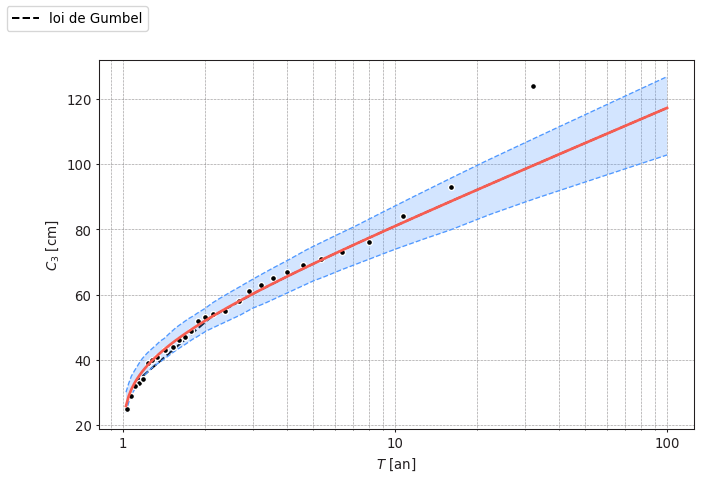

In [69]:
calage_gumbel = gumbel_r.fit(model.extremes.array)
calage_gev    = genextreme.fit(model.extremes.array)

# loi GEV
(xi, mu, sigma) = calage_gev
xi = -xi
période = np.linspace(1.1,100,100)
quantile = mu-sigma/xi*(1-(-np.log(1-1/période))**(-xi))
#axes.plot(période,quantile,'r','-',label = "loi de Fréchet")
# loi Gumbel
(mu, sigma) = calage_gumbel
période = np.linspace(1.1,100,100)
quantile = mu-sigma *np.log(-np.log(1-1/période) )
  
axes.plot(période,quantile,'--',color='black' , label = "loi de Gumbel")
fig.legend(loc="upper left")
fig.savefig("LVE_trois_jours_poste_"+nom_commune+"(" +poste_choisi+").pdf",bbox_inches='tight')
fig

In [70]:
#Estimation des quantiles
summary = model.get_summary(
    return_period=[10, 30, 100],
    alpha=0.7,
    n_samples=1000,
)
summary


return value    lower ci    upper ci
return period                                      
10.0              81.030904   73.560369   87.028507
30.0              98.501462   88.029395  106.666253
100.0            117.234289  103.507507  127.538359

In [71]:
model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                          None      Size:                               3,463
Start:                      December 1994      End:                           April 2025
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 31      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

## Épisodes de précipitations

In [72]:
# remplace nan par 0
valeurs_neige = np.nan_to_num(np.array(données_neige['neige']))
 
série_chute = pd.Series(valeurs_neige,index=np.array(données_neige['date'])).squeeze()

zneige = valeurs_neige !=0
### points de bascule
zneige[1:] ^= zneige[:-1]
#liste des épisodes
liste_épisode=np.split(valeurs_neige, *np.where(zneige))[1::2]

# cherche où est l'épisode
def is_sub_array(original, subarray):
    first_match = np.where(original == subarray[0])
    if len(first_match) == 0:
        return -1
    else:
        for match in first_match[0]:
            cut_original = original[match:match + len(subarray)]
            if (cut_original == subarray).all():
                    return match
             



In [73]:
### scinde valeurs_neige en épisodes
liste_épisode = np.split(valeurs_neige, *np.where(zneige))[1::2]
liste_épisode = np.asarray(liste_épisode, dtype="object") # c'est un tableau de tableaux de taille différente
# cumul de neoige
total_épisode = np.array(list(map((lambda x: np.sum(x)),liste_épisode )))
max_épisode = max(total_épisode )
indice_max  = (np.where(total_épisode==max_épisode)[0] )[0]
épisode_max = liste_épisode[indice_max]
durée_max   = len(épisode_max) 
indice_épisode = is_sub_array(valeurs_neige, épisode_max )
if indice_épisode == 0:
      print(colored("Il y a une erreur, je ne trouve pas la position de l'épisode max.",'red'))
else:
      date_épisode = np.array(données_neige['date'])[indice_épisode]
      date_épisode = datetime.datetime.strptime(str(date_épisode )[0:10] ,"%Y-%m-%d").strftime("%d/%m/%Y")
      print("Le cumul maximal est de {:.0f} cm. C'est un épisode qui a duré {:d} jours et qui commencé le {:s}."
            .format(max_épisode,durée_max,date_épisode ))

 

Le cumul maximal est de 134 cm. C'est un épisode qui a duré 7 jours et qui commencé le 29/12/2017.


In [74]:
seuil_épisode = 50
sélection_épisode = liste_épisode[ total_épisode>seuil_épisode   ] 
sélection_épisode = np.asarray(sélection_épisode, dtype="object") # c'est un tableau de tableaux de taille différente
classement_épisode = []
print("Il y a {:.0f} épisodes dont le cumul dépasse {:.0f} cm :".format(len(sélection_épisode), seuil_épisode))
for i in range(len(sélection_épisode)):
      
      ép = sélection_épisode[i]
      code_sélection = is_sub_array(valeurs_neige, ép)
      total_ép = sum(sélection_épisode[i])

      
      if code_sélection>0:
            date_épisode =  série_chute.iloc[[code_sélection] ].index 
            date_épisode = (date_épisode.strftime("%d/%m/%Y")) [0].strip()
            print("* date :",date_épisode," -- Durée : ", len(ép)," j-- Total = ", total_ép)
            classement_épisode.append([date_épisode, total_ép,len(ép) ])
      else: print("erreur our i =", i, " code =", code_sélection )


Il y a 52 épisodes dont le cumul dépasse 50 cm :
* date : 09/01/1995  -- Durée :  5  j-- Total =  82.0
* date : 20/01/1995  -- Durée :  11  j-- Total =  117.0
* date : 21/02/1995  -- Durée :  7  j-- Total =  106.0
* date : 26/03/1995  -- Durée :  4  j-- Total =  57.0
* date : 19/04/1995  -- Durée :  8  j-- Total =  72.0
* date : 22/12/1995  -- Durée :  12  j-- Total =  101.0
* date : 18/02/1996  -- Durée :  6  j-- Total =  66.0
* date : 18/01/1998  -- Durée :  4  j-- Total =  71.0
* date : 09/04/1998  -- Durée :  5  j-- Total =  57.0
* date : 26/01/1999  -- Durée :  5  j-- Total =  77.0
* date : 04/02/1999  -- Durée :  8  j-- Total =  73.0
* date : 16/02/1999  -- Durée :  9  j-- Total =  78.0
* date : 24/12/1999  -- Durée :  6  j-- Total =  60.0
* date : 13/02/2000  -- Durée :  7  j-- Total =  70.0
* date : 20/02/2002  -- Durée :  5  j-- Total =  52.0
* date : 26/01/2003  -- Durée :  11  j-- Total =  73.0
* date : 11/01/2004  -- Durée :  10  j-- Total =  128.0
* date : 18/01/2005  -- D

In [75]:
classement_épisode_trié = sorted(classement_épisode,key=lambda x: x[1])
print("Liste des épisodes")

print("----------  ---  --")
print("   date    cumul durée")
print(tabulate(classement_épisode_trié))

Liste des épisodes
----------  ---  --
   date    cumul durée
----------  ---  --
20/02/2002   52   5
19/02/2005   52   4
27/12/2021   53   3
19/03/2008   54   9
31/01/2013   54   7
02/02/2017   55   8
21/01/2009   56   4
10/03/2018   56   9
26/03/1995   57   4
09/04/1998   57   5
01/12/2021   59  10
04/01/2025   59   8
24/12/1999   60   6
17/02/2010   62  13
13/04/2012   63   6
22/12/2019   63   3
18/02/1996   66   6
27/02/2006   69   7
25/02/2014   69   8
09/01/2016   69   8
13/02/2000   70   7
18/01/1998   71   4
27/01/2019   71   8
19/04/1995   72   8
06/02/2016   72  11
03/03/2017   72   5
04/02/1999   73   8
26/01/2003   73  11
01/02/2014   74  10
15/01/2018   74   8
21/03/2017   75   5
15/02/2006   76   5
24/03/2010   76   9
19/04/2013   76   2
26/01/1999   77   5
28/02/2009   77  11
07/03/2023   77   8
16/02/1999   78   9
09/01/1995   82   5
18/01/2005   86   8
18/03/2007   92  11
24/02/2007   93   8
14/04/2005   96   7
22/12/1995  101  12
21/01/2021  105  12
21/02/1995  106   

### Valeurs extrêmes

In [76]:
seuil_épisode = 10

try:
      dernière_année_nulle
except NameError:
      dernière_année_nulle = données_neige['date'].dt.year.values[0]


sélection_épisode = liste_épisode[ total_épisode>seuil_épisode   ] 
sélection_épisode = np.asarray(sélection_épisode, dtype="object") # c'est un tableau de tableaux de taille différente
classement_épisode = list()
for i in range(len(sélection_épisode)):
      ép = sélection_épisode[i]
      code_sélection = is_sub_array(valeurs_neige, ép)
      total_ép = sum(sélection_épisode[i])
      if code_sélection>0:
            date_épisode =  série_chute.iloc[[code_sélection] ].index 
            date_épisode = (date_épisode.strftime("%Y-%m-%d")) [0].strip()
            classement_épisode.append([date_épisode, total_ép,len(ép) ])
      else: print("erreur our i =", i, " code =", code_sélection )

dates_classement = np.array(classement_épisode)[:,0]
cumul_classement = np.array(classement_épisode)[:,1]
série_épisode = pd.Series({'date':dates_classement, 'cumul':cumul_classement} )
série_épisode['date']=pd.to_datetime(série_épisode['date'])

In [77]:
série_2 = pd.Series(série_épisode['cumul'],index=série_épisode['date']).squeeze()
série_3 = série_2
#série_3 = série_2[série_2.index>=dernière_année_nulle] # en cas de souci avec des valeurs nulles
model = EVA(série_3)

/home/ancey/anaconda3/envs/python3.12/lib/python3.12/site-packages/pyextremes/eva.py:91: RuntimeWarning: `data` values are not numeric - converting to numeric
  warnings.warn(message=message, category=RuntimeWarning)
/home/ancey/anaconda3/envs/python3.12/lib/python3.12/site-packages/pyextremes/eva.py:111: RuntimeWarning: 21 duplicate indices found in `data` - removing duplicate entries
  warnings.warn(message=message, category=RuntimeWarning)


                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                          None      Size:                                 259
Start:                      December 1994      End:                           March 2025
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 31      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

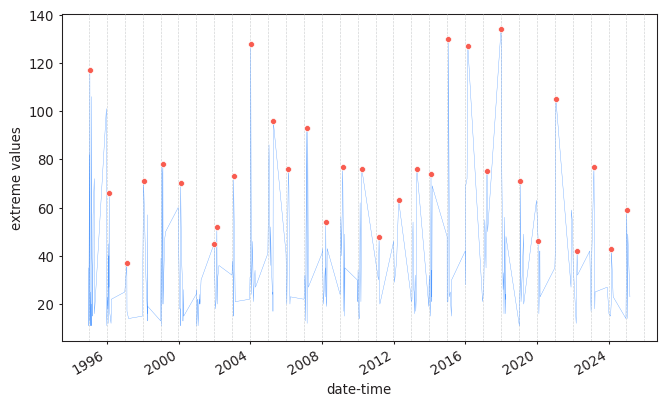

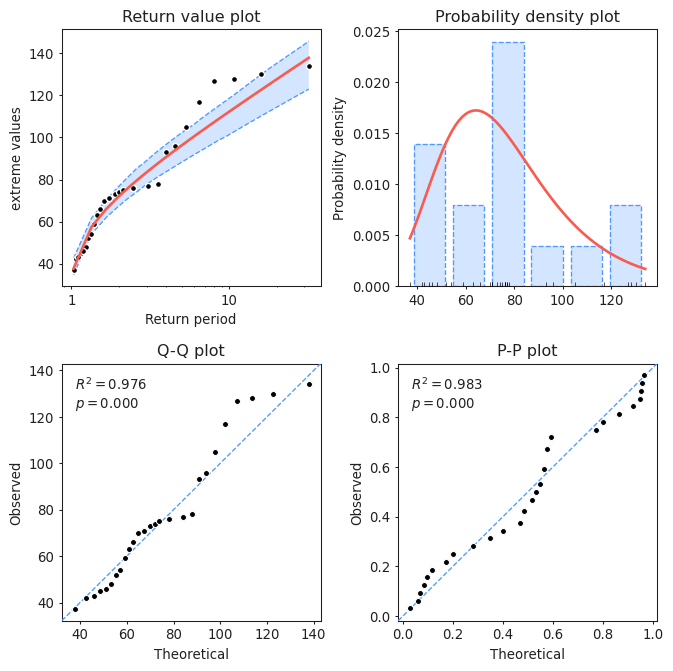

In [78]:
model.get_extremes(
    method="BM",
    extremes_type="high",
    block_size="365.2425D",
    errors="raise",
)

model.plot_extremes()

model.fit_model()
model.plot_diagnostic(alpha=0.7)
model

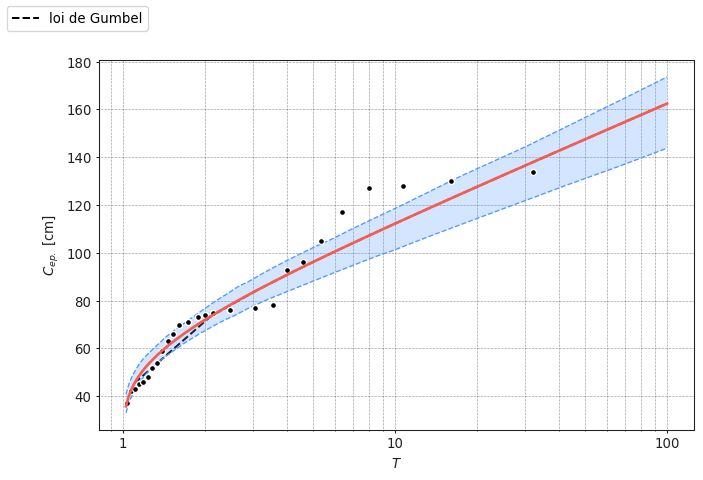

In [79]:
fig, axes = model.plot_return_values(
    return_period=np.logspace(0.01, 2, 200),
    return_period_size="365.2425D",
    alpha=0.7,
)
axes.set_xlabel(r"$T$")
axes.set_ylabel(r"$C_{ep.}$ [cm]")


calage_gumbel = gumbel_r.fit(model.extremes.array)
calage_gev    = genextreme.fit(model.extremes.array)

# loi GEV
(xi, mu, sigma) = calage_gev
xi = -xi
période = np.linspace(1.1,100,100)
quantile = mu-sigma/xi*(1-(-np.log(1-1/période))**(-xi))
#axes.plot(période,quantile,'r','-',label = "loi de Fréchet")
# loi Gumbel
(mu, sigma) = calage_gumbel
période = np.linspace(1.1,100,100)
quantile = mu-sigma *np.log(-np.log(1-1/période) )
  
axes.plot(période,quantile,'--',color='black' , label = "loi de Gumbel")
fig.legend(loc="upper left")
fig.savefig("LVE_Episode_poste_"+nom_commune+"(" +poste_choisi+").pdf",bbox_inches='tight')


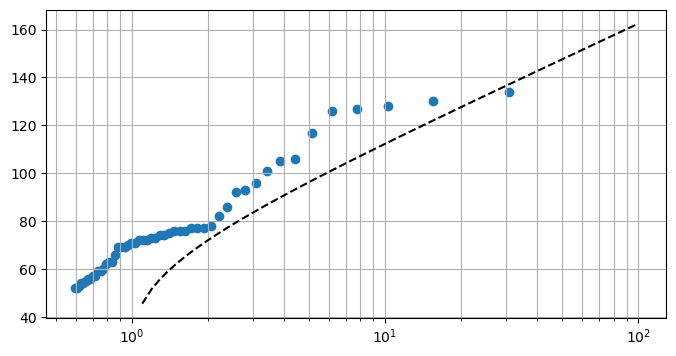

In [80]:
def période_quantile(c,m,s):
      return 1/(1-np.exp(-np.exp(-(c-m)/s)))
fig, ax = plt.subplots(figsize=(8,4))
(mu, sigma) = calage_gumbel
période = np.linspace(1.1,100,1000)
quantile = mu-sigma *np.log(-np.log(1-1/période) )
  
ax.semilogx(période,quantile,'--',color='black' , label = "loi de Gumbel")
y_cumul = [ float(x) for x in np.array(classement_épisode_trié)[:,1]  ]
n_s = len(y_cumul) 
n_o = (données_neige['date'].iloc[-1]-données_neige['date'].iloc[0])/ np.timedelta64(1, 'D')/365.25/n_s
x_cumul = [ n_o*(n_s+1)/(i  ) for i in range(n_s,0,-1)  ]

ax.scatter(x_cumul,y_cumul)
ax.grid(True, which="both")


 


In [81]:
classement_épisode_trié_période = [[x[0],x[1],x[2],int(période_quantile(x[1],mu,sigma))] for x in classement_épisode_trié]

print("Liste des épisodes")

print("----------  ---  -- --")
print("   date    cumul  d  T")
print(tabulate(classement_épisode_trié_période))

Liste des épisodes
----------  ---  -- --
   date    cumul  d  T
----------  ---  --  --
20/02/2002   52   5   1
19/02/2005   52   4   1
27/12/2021   53   3   1
19/03/2008   54   9   1
31/01/2013   54   7   1
02/02/2017   55   8   1
21/01/2009   56   4   1
10/03/2018   56   9   1
26/03/1995   57   4   1
09/04/1998   57   5   1
01/12/2021   59  10   1
04/01/2025   59   8   1
24/12/1999   60   6   1
17/02/2010   62  13   1
13/04/2012   63   6   1
22/12/2019   63   3   1
18/02/1996   66   6   1
27/02/2006   69   7   1
25/02/2014   69   8   1
09/01/2016   69   8   1
13/02/2000   70   7   1
18/01/1998   71   4   1
27/01/2019   71   8   1
19/04/1995   72   8   1
06/02/2016   72  11   1
03/03/2017   72   5   1
04/02/1999   73   8   2
26/01/2003   73  11   2
01/02/2014   74  10   2
15/01/2018   74   8   2
21/03/2017   75   5   2
15/02/2006   76   5   2
24/03/2010   76   9   2
19/04/2013   76   2   2
26/01/1999   77   5   2
28/02/2009   77  11   2
07/03/2023   77   8   2
16/02/1999   78   9   2

In [82]:
# Export au format latex
print(tabulate(classement_épisode_trié_période, tablefmt="latex"))

\begin{tabular}{lrrr}
\hline
 20/02/2002 &  52 &  5 &  1 \\
 19/02/2005 &  52 &  4 &  1 \\
 27/12/2021 &  53 &  3 &  1 \\
 19/03/2008 &  54 &  9 &  1 \\
 31/01/2013 &  54 &  7 &  1 \\
 02/02/2017 &  55 &  8 &  1 \\
 21/01/2009 &  56 &  4 &  1 \\
 10/03/2018 &  56 &  9 &  1 \\
 26/03/1995 &  57 &  4 &  1 \\
 09/04/1998 &  57 &  5 &  1 \\
 01/12/2021 &  59 & 10 &  1 \\
 04/01/2025 &  59 &  8 &  1 \\
 24/12/1999 &  60 &  6 &  1 \\
 17/02/2010 &  62 & 13 &  1 \\
 13/04/2012 &  63 &  6 &  1 \\
 22/12/2019 &  63 &  3 &  1 \\
 18/02/1996 &  66 &  6 &  1 \\
 27/02/2006 &  69 &  7 &  1 \\
 25/02/2014 &  69 &  8 &  1 \\
 09/01/2016 &  69 &  8 &  1 \\
 13/02/2000 &  70 &  7 &  1 \\
 18/01/1998 &  71 &  4 &  1 \\
 27/01/2019 &  71 &  8 &  1 \\
 19/04/1995 &  72 &  8 &  1 \\
 06/02/2016 &  72 & 11 &  1 \\
 03/03/2017 &  72 &  5 &  1 \\
 04/02/1999 &  73 &  8 &  2 \\
 26/01/2003 &  73 & 11 &  2 \\
 01/02/2014 &  74 & 10 &  2 \\
 15/01/2018 &  74 &  8 &  2 \\
 21/03/2017 &  75 &  5 &  2 \\
 15/02/200